In [1]:
import pandas as pd
import numpy
import river
from river import stream
from river import compose
from river import preprocessing

from river import evaluate
from river import metrics
from river import tree
from river import imblearn
from river import stats
import numbers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from collections import Counter
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.linear_model import SGDClassifier
from river import datasets, compose, linear_model, metrics
import random
from river import metrics
from river import linear_model, naive_bayes, tree
from river.datasets import Higgs
from river import metrics
#from river import linear_model
from river import naive_bayes
from river import ensemble
from river import neighbors
from river import tree
from river import preprocessing
from river import compat
from river import imblearn
from river import optim
from sklearn.preprocessing import LabelEncoder
import warnings
from imblearn.over_sampling import RandomOverSampler
from river import feature_selection
import operator
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from river import (
    linear_model, 
    naive_bayes, 
    tree, 
    ensemble, 
    neural_net, 
    preprocessing,
)
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from river import model_selection
from river import utils
from river import optim
import time
from sklearn.metrics import confusion_matrix
from collections import deque
from river import datasets
from river import evaluate
from river import metrics
from river import stream
from river import tree
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from river import forest

sns.set_style("whitegrid")
# Set the style to ticks
sns.set_style("ticks")

warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('online_shoppers_intention.csv')

In [3]:
Month={'Feb':2, 'Mar':3, 'May':5,  'June':6,'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df['Month']=df['Month'].map(Month)

VisitorType={'Returning_Visitor':0, 'New_Visitor':1, 'Other':2}
df['VisitorType']=df['VisitorType'].map(VisitorType)
d={True:1,False:0}
df['Weekend']=df['Weekend'].map(d)
df['Revenue']=df['Revenue'].map(d)

In [4]:
# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42,stratify=df['Revenue'])


# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 17), label shape: (9864,)
Test set shape: (2466, 17), label shape: (2466,)


In [5]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

In [6]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

Training time: 7.09 seconds
Accuracy Train: 0.786699107866991
Balanced Accuracy Train: 0.7603311215182146
AUC 0.7603311215182146
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.01%   79.85%   86.36%      8338  
       1      39.61%   72.21%   51.16%      1526  
                                                  
   Macro      66.81%   76.03%   68.76%            
   Micro      78.67%   78.67%   78.67%            
Weighted      85.60%   78.67%   80.91%            

                 78.67% accuracy                  
Accuracy: 0.7952149229521492
Precision: [0.92837765 0.40128411]
Recall: [0.82101727 0.65445026]
F1 Score: [0.87140311 0.49751244]
Specifity: 0.8210172744721689
Balanced Accuracy: 0.7377337681261368
AUC: 0.7377337681261368
Confusion matrix:
[[1711  373]
 [ 132  250]]


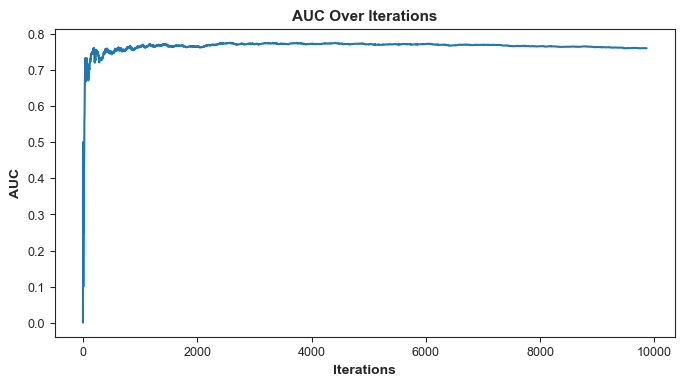

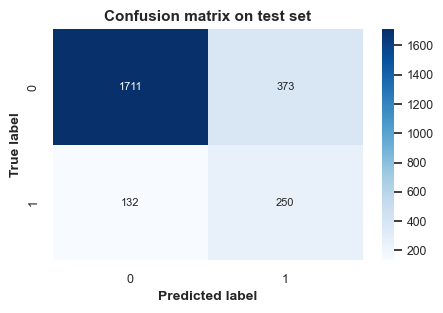

In [7]:
naive_without_oversampling=train_evaluate_model((
    preprocessing.StandardScaler() | 
        naive_bayes.GaussianNB()))

Training time: 4.19 seconds
Accuracy Train: 0.8220802919708029
Balanced Accuracy Train: 0.680876559716336
AUC 0.6808765597163361
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      90.23%   88.53%   89.38%      8338  
       1      43.20%   47.64%   45.31%      1526  
                                                  
   Macro      66.72%   68.09%   67.34%            
   Micro      82.21%   82.21%   82.21%            
Weighted      82.96%   82.21%   82.56%            

                 82.21% accuracy                  
Accuracy: 0.8260340632603407
Precision: [0.89498807 0.43665768]
Recall: [0.89971209 0.42408377]
F1 Score: [0.89734386 0.43027888]
Specifity: 0.8997120921305183
Balanced Accuracy: 0.6618979308820131
AUC: 0.6618979308820131
Confusion matrix:
[[1875  209]
 [ 220  162]]


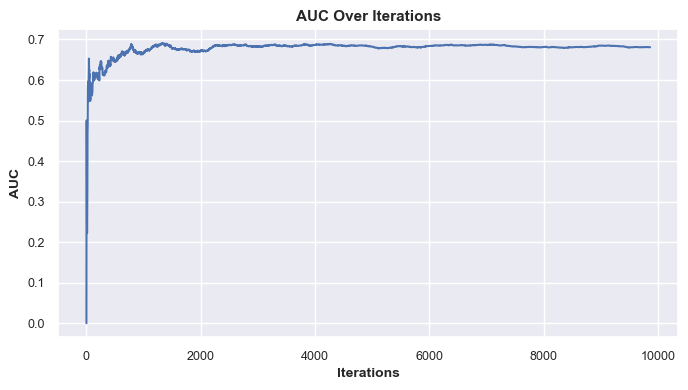

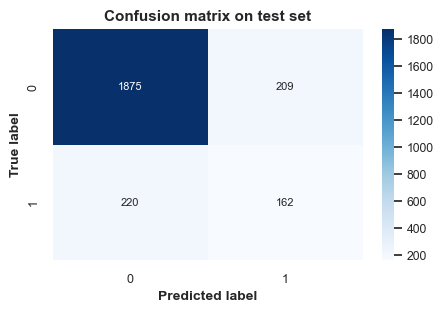

In [8]:
passive_aggressive_without_oversampling=train_evaluate_model((
    preprocessing.StandardScaler() | 
        river.linear_model.PAClassifier()))

Training time: 4.72 seconds
Accuracy Train: 0.8790551500405515
Balanced Accuracy Train: 0.6717476745132818
AUC 0.6717476745132817
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      89.42%   97.19%   93.14%      8338  
       1      70.79%   37.16%   48.73%      1526  
                                                  
   Macro      80.10%   67.17%   70.94%            
   Micro      87.91%   87.91%   87.91%            
Weighted      86.54%   87.91%   86.27%            

                 87.91% accuracy                  
Accuracy: 0.8787510137875101
Precision: [0.88888889 0.74269006]
Recall: [0.97888676 0.33246073]
F1 Score: [0.93171957 0.45931284]
Specifity: 0.9788867562380038
Balanced Accuracy: 0.6556737446111485
AUC: 0.6556737446111486
Confusion matrix:
[[2040   44]
 [ 255  127]]


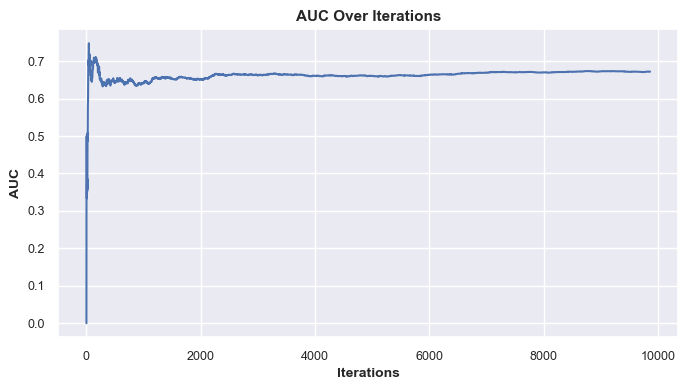

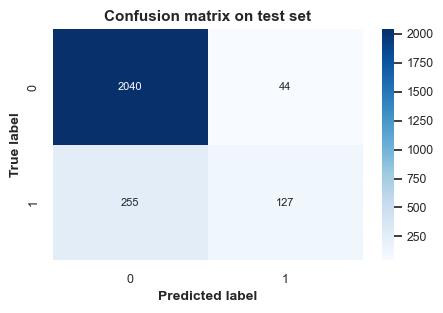

In [9]:
SGD_without_oversampling=train_evaluate_model(
    preprocessing.StandardScaler() | # or adaptive
        river.linear_model.LogisticRegression(optimizer=optim.SGD()))

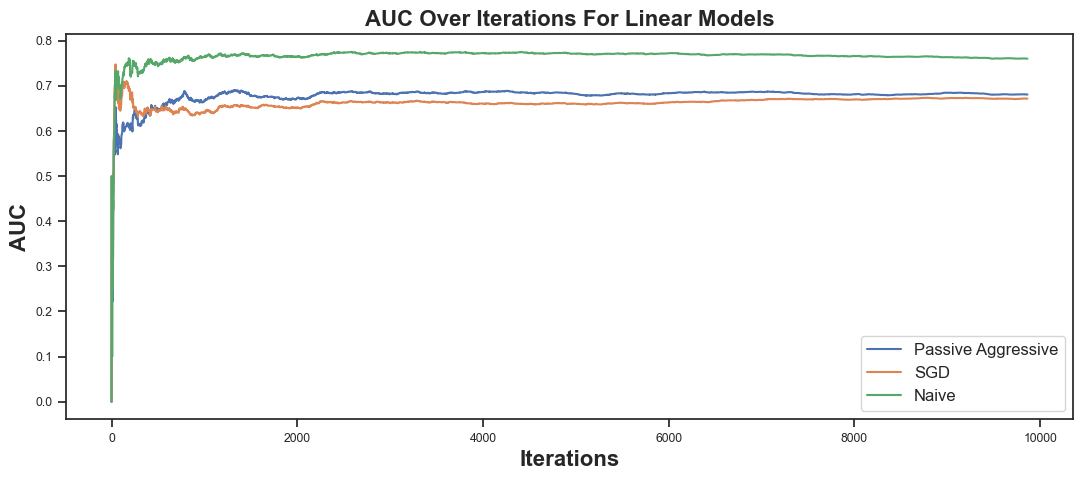

In [10]:
fig = plt.figure(figsize=(13,5))
sns.set_style("whitegrid")
# Set the style to ticks
sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(SGD_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_without_oversampling[0], label='Passive Aggressive')
plt.plot(x, SGD_without_oversampling[0], label='SGD')
plt.plot(x, naive_without_oversampling[0], label='Naive')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC Over Iterations For Linear Models', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot

plt.show()

# Save the figure
#fig.savefig('balanced_linear.png')

### Tree - Based

Training time: 9.53 seconds
Accuracy Train: 0.8856447688564477
Balanced Accuracy Train: 0.7465827000575616
AUC 0.7465827000575616
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      91.93%   94.79%   93.34%      8338  
       1      65.72%   54.52%   59.60%      1526  
                                                  
   Macro      78.82%   74.66%   76.47%            
   Micro      88.56%   88.56%   88.56%            
Weighted      87.87%   88.56%   88.12%            

                 88.56% accuracy                  
Accuracy: 0.8832116788321168
Precision: [0.91923436 0.64506173]
Recall: [0.94481766 0.54712042]
F1 Score: [0.93185045 0.59206799]
Specifity: 0.9448176583493282
Balanced Accuracy: 0.7459690385987479
AUC: 0.7459690385987479
Confusion matrix:
[[1969  115]
 [ 173  209]]


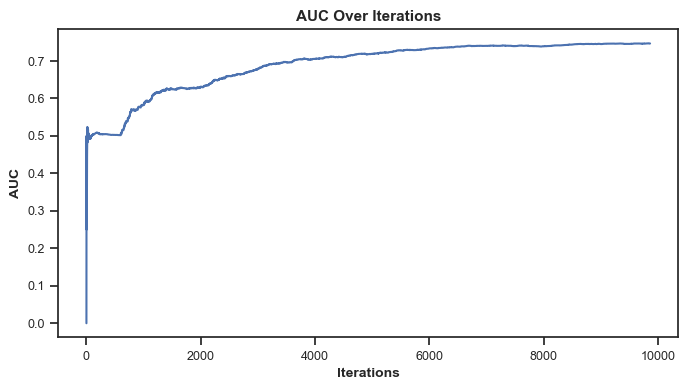

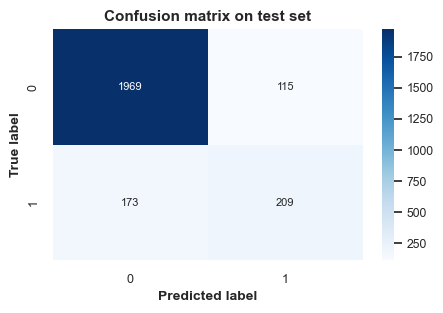

In [11]:
HoeffdingTree_without_oversampling=train_evaluate_model(preprocessing.StandardScaler()|tree.HoeffdingTreeClassifier())

Training time: 48.73 seconds
Accuracy Train: 0.883110300081103
Balanced Accuracy Train: 0.7659631707161421
AUC 0.7659631707161421
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      92.68%   93.56%   93.12%      8338  
       1      62.89%   59.63%   61.22%      1526  
                                                  
   Macro      77.79%   76.60%   77.17%            
   Micro      88.31%   88.31%   88.31%            
Weighted      88.07%   88.31%   88.18%            

                 88.31% accuracy                  
Accuracy: 0.8819951338199513
Precision: [0.91256328 0.6552901 ]
Recall: [0.95153551 0.5026178 ]
F1 Score: [0.931642   0.56888889]
Specifity: 0.9515355086372361
Balanced Accuracy: 0.7270766548421783
AUC: 0.7270766548421783
Confusion matrix:
[[1983  101]
 [ 190  192]]


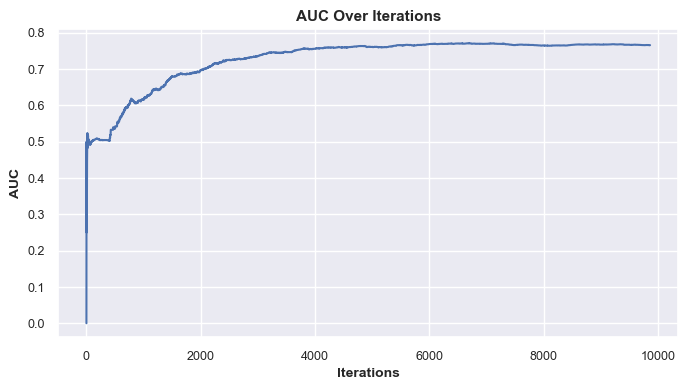

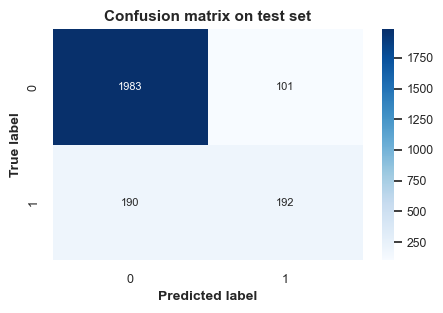

In [12]:
Extremely_fast_without_oversampling=train_evaluate_model(preprocessing.StandardScaler()|tree.ExtremelyFastDecisionTreeClassifier())

Training time: 11.07 seconds
Accuracy Train: 0.8833130575831306
Balanced Accuracy Train: 0.7366374699106901
AUC 0.7366374699106901
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      91.60%   94.90%   93.22%      8338  
       1      65.31%   52.42%   58.16%      1526  
                                                  
   Macro      78.45%   73.66%   75.69%            
   Micro      88.33%   88.33%   88.33%            
Weighted      87.53%   88.33%   87.80%            

                 88.33% accuracy                  
Accuracy: 0.8864557988645579
Precision: [0.91037307 0.69029851]
Recall: [0.96017274 0.48429319]
F1 Score: [0.93461    0.56923077]
Specifity: 0.960172744721689
Balanced Accuracy: 0.7222329692194832
AUC: 0.7222329692194831
Confusion matrix:
[[2001   83]
 [ 197  185]]


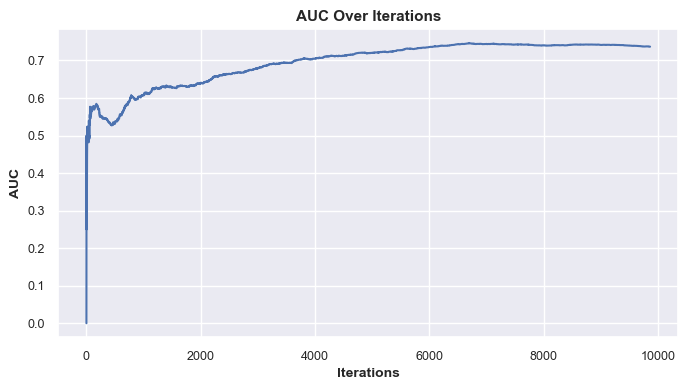

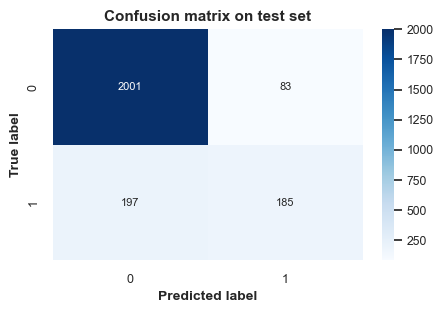

In [13]:
adaptive_hoeffdingTree_without_oversampling=train_evaluate_model(preprocessing.StandardScaler()|tree.HoeffdingAdaptiveTreeClassifier())

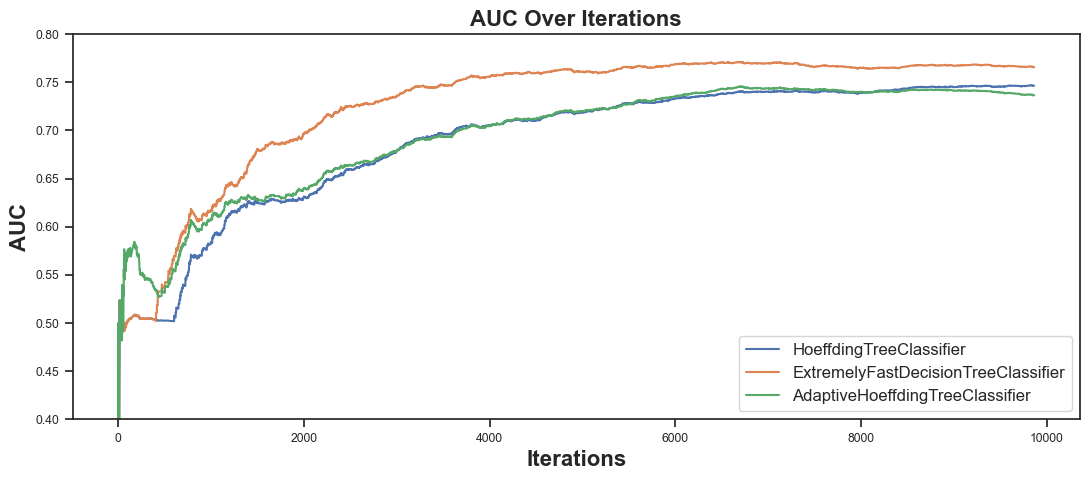

In [14]:
fig = plt.figure(figsize=(13,5))

sns.set_style("whitegrid")
# Set the style to ticks
sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, HoeffdingTree_without_oversampling[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_without_oversampling[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, adaptive_hoeffdingTree_without_oversampling[0], label='AdaptiveHoeffdingTreeClassifier')

# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.4, 0.8)
# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot
plt.show()

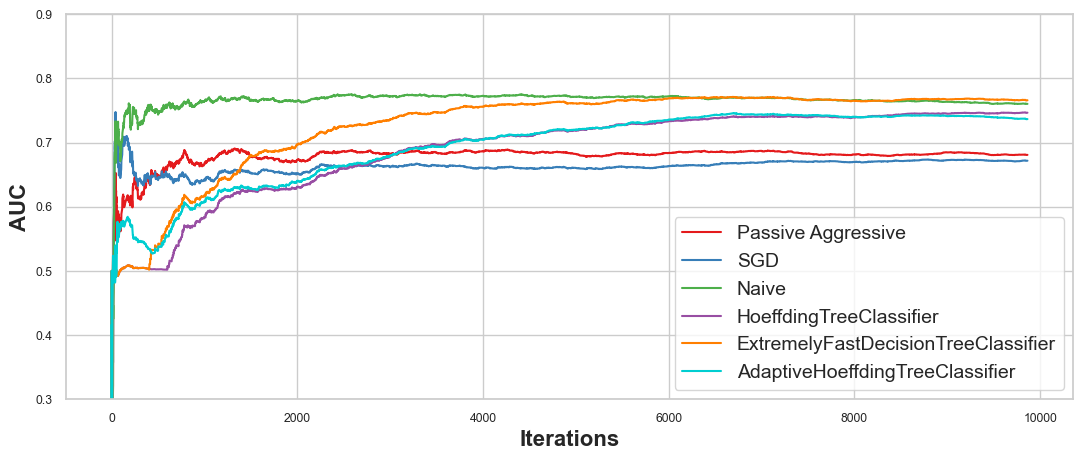

In [15]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")


# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_without_oversampling[0], label='Passive Aggressive')
plt.plot(x, SGD_without_oversampling[0], label='SGD')
plt.plot(x, naive_without_oversampling[0], label='Naive')
plt.plot(x, HoeffdingTree_without_oversampling[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_without_oversampling[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, adaptive_hoeffdingTree_without_oversampling[0], label='AdaptiveHoeffdingTreeClassifier',color='darkturquoise')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
#plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.3, 0.9)
# Add legend
plt.legend(loc='lower right',fontsize=14)

# Show the plot
plt.show()

fig.savefig('auc_original_dataset_final.png')

## Oversampling

## Linear Models

Training time: 7.56 seconds
Accuracy Train: 0.64882400648824
Balanced Accuracy Train: 0.7416833729075021
AUC 0.7416833729075021
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.40%   60.72%   74.51%      8338  
       1      28.99%   87.61%   43.56%      1526  
                                                  
   Macro      62.70%   74.17%   59.04%            
   Micro      64.88%   64.88%   64.88%            
Weighted      85.97%   64.88%   69.72%            

                 64.88% accuracy                  
Accuracy: 0.6642335766423357
Precision: [0.94793153 0.29041353]
Recall: [0.63771593 0.80890052]
F1 Score: [0.76247849 0.42738589]
Specifity: 0.6377159309021113
Balanced Accuracy: 0.7233082272311604
AUC: 0.7233082272311604
Confusion matrix:
[[1329  755]
 [  73  309]]


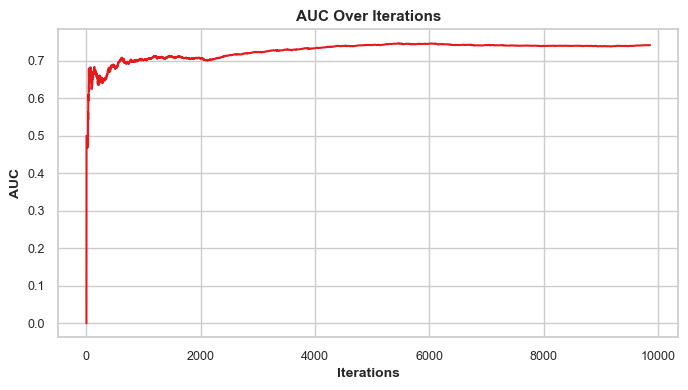

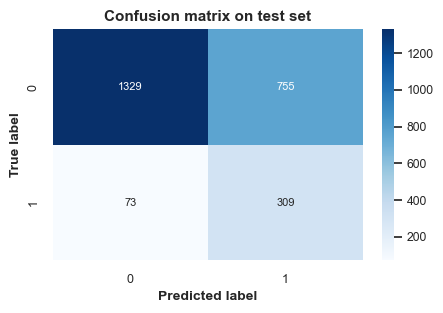

In [16]:
#model = naive_bayes.GaussianNB()

naive=train_evaluate_model((
    preprocessing.StandardScaler() | # or adaptive
    imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### Passive Aggressive Optimization 

### C=1

Training time: 3.70 seconds
Accuracy Train: 0.8218775344687753
Balanced Accuracy Train: 0.6802212517215784
AUC 0.6802212517215785
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      90.21%   88.53%   89.37%      8338  
       1      43.13%   47.51%   45.21%      1526  
                                                  
   Macro      66.67%   68.02%   67.29%            
   Micro      82.19%   82.19%   82.19%            
Weighted      82.93%   82.19%   82.53%            

                 82.19% accuracy                  
Accuracy: 0.8260340632603407
Precision: [0.89498807 0.43665768]
Recall: [0.89971209 0.42408377]
F1 Score: [0.89734386 0.43027888]
Specifity: 0.8997120921305183
Balanced Accuracy: 0.6618979308820131
AUC: 0.6618979308820131
Confusion matrix:
[[1875  209]
 [ 220  162]]


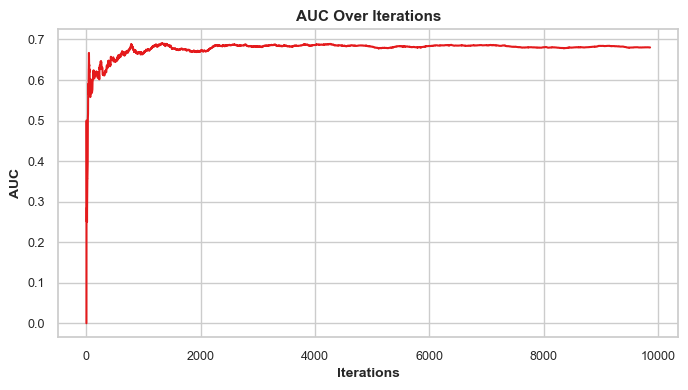

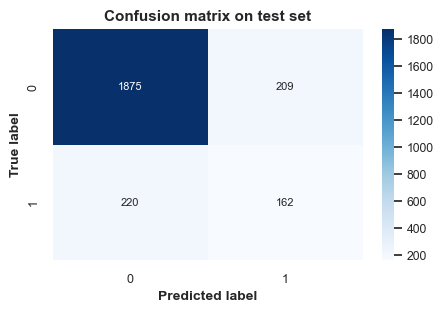

In [108]:
passive_aggressive_1=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=1),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### C=0.1

Training time: 3.86 seconds
Accuracy Train: 0.8381995133819952
Balanced Accuracy Train: 0.7134323520637094
AUC 0.7134323520637094
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      91.27%   89.41%   90.33%      8338  
       1      47.94%   53.28%   50.47%      1526  
                                                  
   Macro      69.60%   71.34%   70.40%            
   Micro      83.82%   83.82%   83.82%            
Weighted      84.57%   83.82%   84.16%            

                 83.82% accuracy                  
Accuracy: 0.7875101378751014
Precision: [0.91269841 0.37673611]
Recall: [0.82773512 0.56806283]
F1 Score: [0.86814293 0.45302714]
Specifity: 0.8277351247600768
Balanced Accuracy: 0.6978989759926039
AUC: 0.6978989759926039
Confusion matrix:
[[1725  359]
 [ 165  217]]


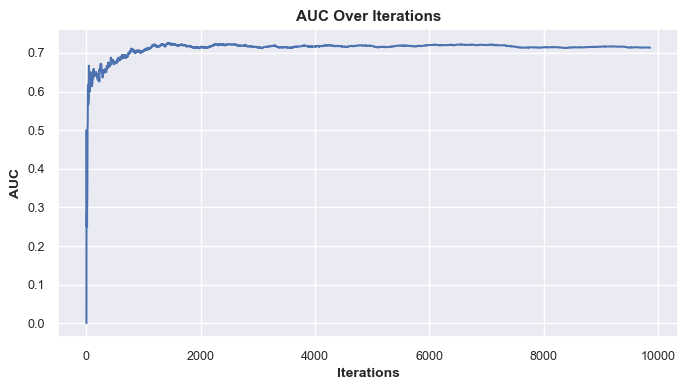

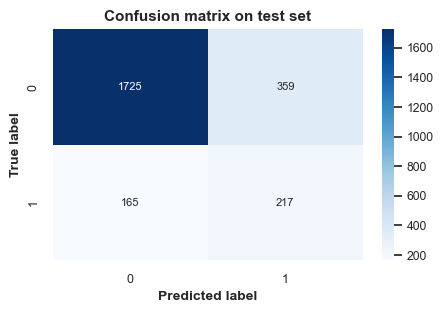

In [109]:
passive_aggressive_01=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.1),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### C=0.01

Training time: 3.64 seconds
Accuracy Train: 0.8579683698296837
Balanced Accuracy Train: 0.7891031350097942
AUC 0.7891031350097943
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      93.99%   88.88%   91.36%      8338  
       1      53.16%   68.94%   60.03%      1526  
                                                  
   Macro      73.57%   78.91%   75.70%            
   Micro      85.80%   85.80%   85.80%            
Weighted      87.67%   85.80%   86.52%            

                 85.80% accuracy                  
Accuracy: 0.864963503649635
Precision: [0.93320139 0.55505618]
Recall: [0.9049904  0.64659686]
F1 Score: [0.91887942 0.59733978]
Specifity: 0.9049904030710173
Balanced Accuracy: 0.7757936308548804
AUC: 0.7757936308548803
Confusion matrix:
[[1886  198]
 [ 135  247]]


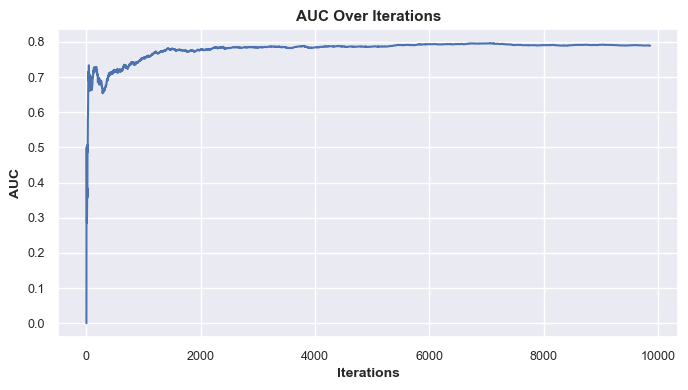

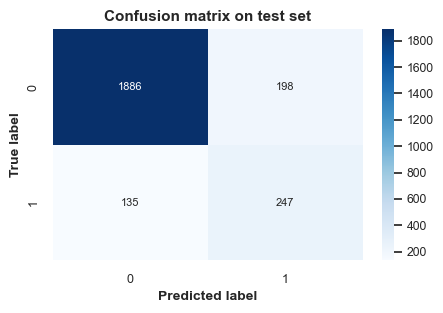

In [110]:
passive_aggressive_001=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.01),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### C=0.001

Training time: 2.94 seconds
Accuracy Train: 0.8404298459042985
Balanced Accuracy Train: 0.7998762632637387
AUC 0.7998762632637387
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.77%   85.86%   90.10%      8338  
       1      48.96%   74.12%   58.97%      1526  
                                                  
   Macro      71.87%   79.99%   74.53%            
   Micro      84.04%   84.04%   84.04%            
Weighted      87.68%   84.04%   85.28%            

                 84.04% accuracy                  
Accuracy: 0.8600973236009732
Precision: [0.94159472 0.53722334]
Recall: [0.88963532 0.69895288]
F1 Score: [0.91487787 0.60750853]
Specifity: 0.8896353166986565
Balanced Accuracy: 0.7942940981399041
AUC: 0.7942940981399041
Confusion matrix:
[[1854  230]
 [ 115  267]]


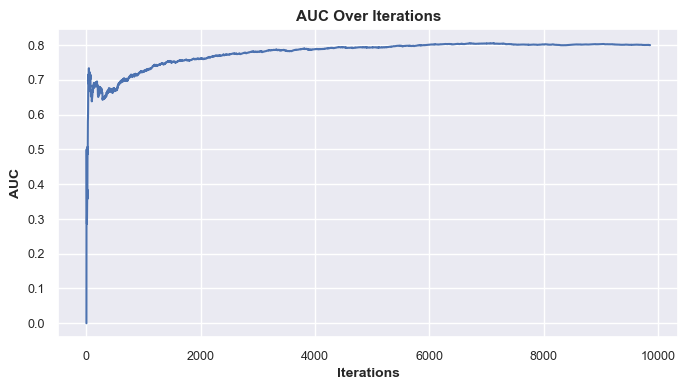

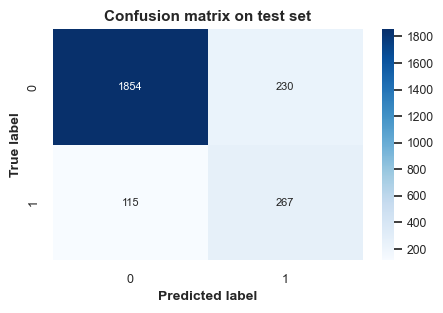

In [111]:
passive_aggressive_0001=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### C=0.0001

Training time: 3.27 seconds
Accuracy Train: 0.7081305758313058
Balanced Accuracy Train: 0.7684654129729291
AUC 0.7684654129729291
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.27%   68.11%   79.78%      8338  
       1      32.94%   85.58%   47.57%      1526  
                                                  
   Macro      64.60%   76.85%   63.67%            
   Micro      70.81%   70.81%   70.81%            
Weighted      86.47%   70.81%   74.80%            

                 70.81% accuracy                  
Accuracy: 0.732360097323601
Precision: [0.9523507 0.3441704]
Recall: [0.71928983 0.80366492]
F1 Score: [0.81957354 0.48194662]
Specifity: 0.7192898272552783
Balanced Accuracy: 0.7614773743606235
AUC: 0.7614773743606236
Confusion matrix:
[[1499  585]
 [  75  307]]


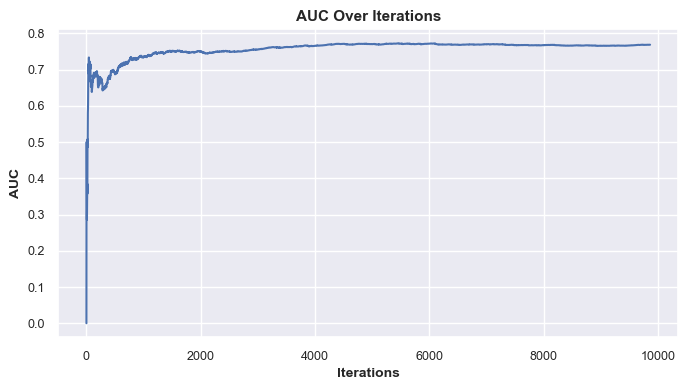

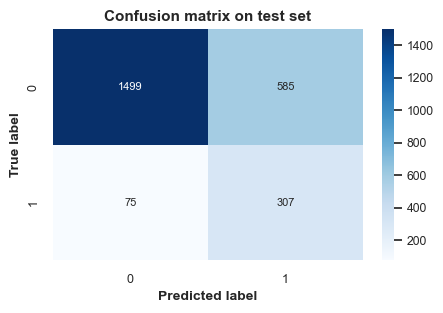

In [112]:
passive_aggressive_00001=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.0001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

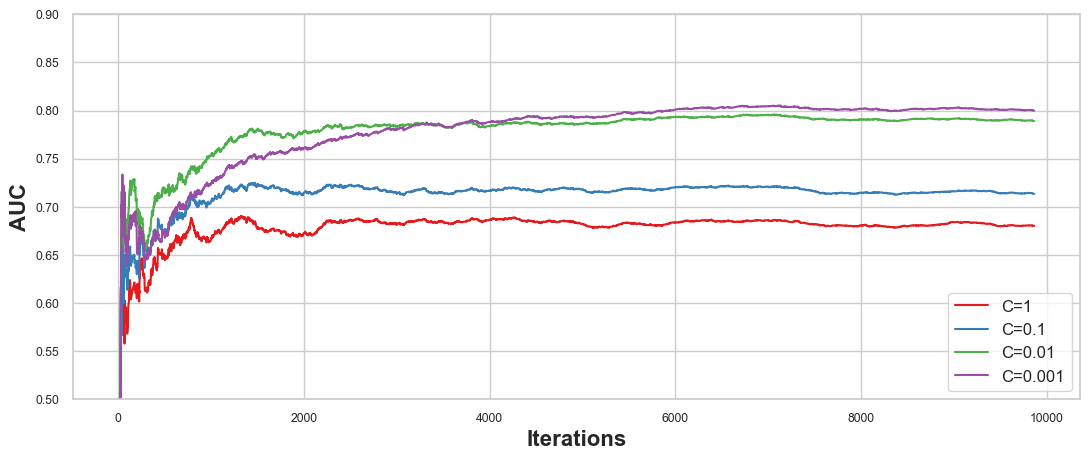

In [113]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_1[0], label='C=1')
plt.plot(x, passive_aggressive_01[0], label='C=0.1')
#plt.plot(x, passive_aggressive_05, label='C=0.5')
plt.plot(x, passive_aggressive_001[0], label='C=0.01')
#plt.plot(x, passive_aggressive_005, label='C=0.05')
plt.plot(x, passive_aggressive_0001[0], label='C=0.001')
#plt.plot(x, passive_aggressive_0005, label='C=0.005')
#plt.plot(x, passive_aggressive_00001[0], label='C=0.0001',color='lightblue')

# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
#plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.5,0.9)
# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot
plt.show()


fig.savefig('passive_aggressive_hyperparametes.png')

### SGD optimization

In [ ]:
preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.01)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )

### lr=0.01

Training time: 4.69 seconds
Accuracy Train: 0.8432684509326845
Balanced Accuracy Train: 0.7945954459473861
AUC 0.7945954459473862
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.49%   86.51%   90.32%      8338  
       1      49.55%   72.41%   58.84%      1526  
                                                  
   Macro      72.02%   79.46%   74.58%            
   Micro      84.33%   84.33%   84.33%            
Weighted      87.53%   84.33%   85.45%            

                 84.33% accuracy                  
Accuracy: 0.8276561232765612
Precision: [0.9358907  0.46181172]
Recall: [0.85460653 0.68062827]
F1 Score: [0.89340356 0.55026455]
Specifity: 0.8546065259117083
Balanced Accuracy: 0.7676173990815086
AUC: 0.7676173990815087
Confusion matrix:
[[1781  303]
 [ 122  260]]


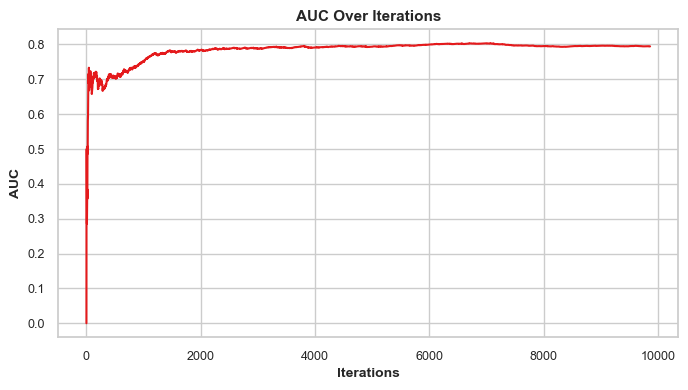

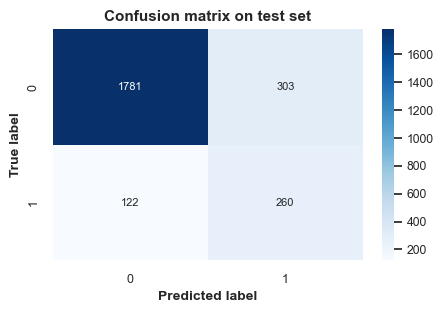

In [114]:
SGD_01=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.01)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### lr=0.001

Training time: 2.86 seconds
Accuracy Train: 0.832522303325223
Balanced Accuracy Train: 0.7930573819683258
AUC 0.7930573819683256
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.62%   85.02%   89.56%      8338  
       1      47.34%   73.59%   57.62%      1526  
                                                  
   Macro      70.98%   79.31%   73.59%            
   Micro      83.25%   83.25%   83.25%            
Weighted      87.31%   83.25%   84.62%            

                 83.25% accuracy                  
Accuracy: 0.8337388483373885
Precision: [0.94616205 0.47627119]
Recall: [0.85172745 0.73560209]
F1 Score: [0.89646465 0.5781893 ]
Specifity: 0.8517274472168906
Balanced Accuracy: 0.7936647707288642
AUC: 0.793664770728864
Confusion matrix:
[[1775  309]
 [ 101  281]]


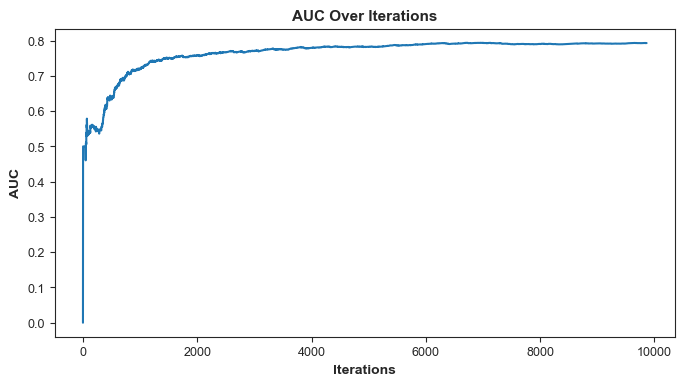

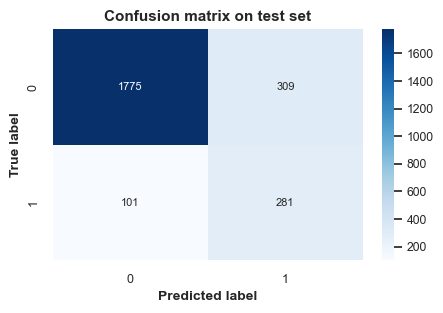

In [7]:
SGD_001=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### lr=0.0001

Training time: 4.31 seconds
Accuracy Train: 0.7622668288726683
Balanced Accuracy Train: 0.7268733965073924
AUC 0.7268733965073924
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      92.91%   77.81%   84.69%      8338  
       1      35.79%   67.56%   46.79%      1526  
                                                  
   Macro      64.35%   72.69%   65.74%            
   Micro      76.23%   76.23%   76.23%            
Weighted      84.07%   76.23%   78.83%            

                 76.23% accuracy                  
Accuracy: 0.8021086780210868
Precision: [0.93702081 0.4171875 ]
Recall: [0.82101727 0.69895288]
F1 Score: [0.87519182 0.52250489]
Specifity: 0.8210172744721689
Balanced Accuracy: 0.7599850770266603
AUC: 0.7599850770266603
Confusion matrix:
[[1711  373]
 [ 115  267]]


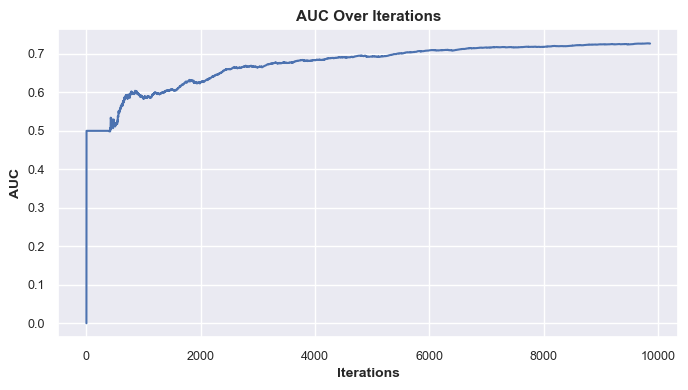

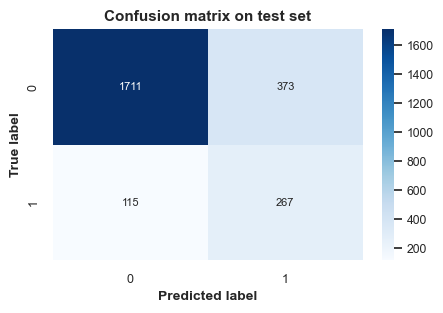

In [116]:
SGD_0001=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.0001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### lr=0.1

Training time: 3.34 seconds
Accuracy Train: 0.8353609083536091
Balanced Accuracy Train: 0.7390574253516327
AUC 0.7390574253516327
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      92.30%   87.85%   90.02%      8338  
       1      47.46%   59.96%   52.98%      1526  
                                                  
   Macro      69.88%   73.91%   71.50%            
   Micro      83.54%   83.54%   83.54%            
Weighted      85.36%   83.54%   84.29%            

                 83.54% accuracy                  
Accuracy: 0.7846715328467153
Precision: [0.91106406 0.37088388]
Recall: [0.82581574 0.56020942]
F1 Score: [0.86634785 0.44629823]
Specifity: 0.8258157389635317
Balanced Accuracy: 0.6930125815236506
AUC: 0.6930125815236506
Confusion matrix:
[[1721  363]
 [ 168  214]]


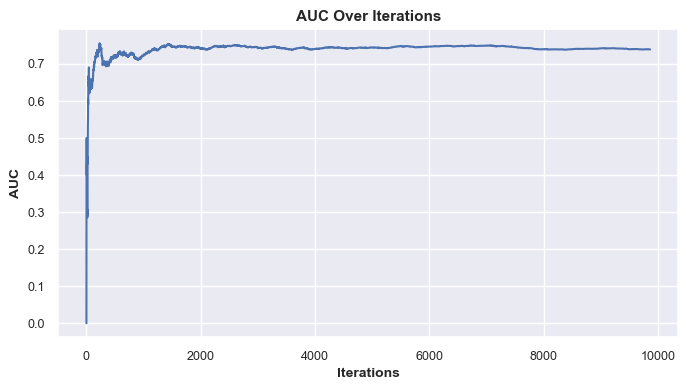

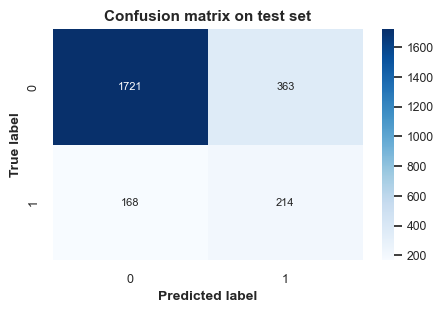

In [117]:
SGD_1=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.1)),
        desired_dist={0: .6, 1: .4},
        seed=42
    )
))

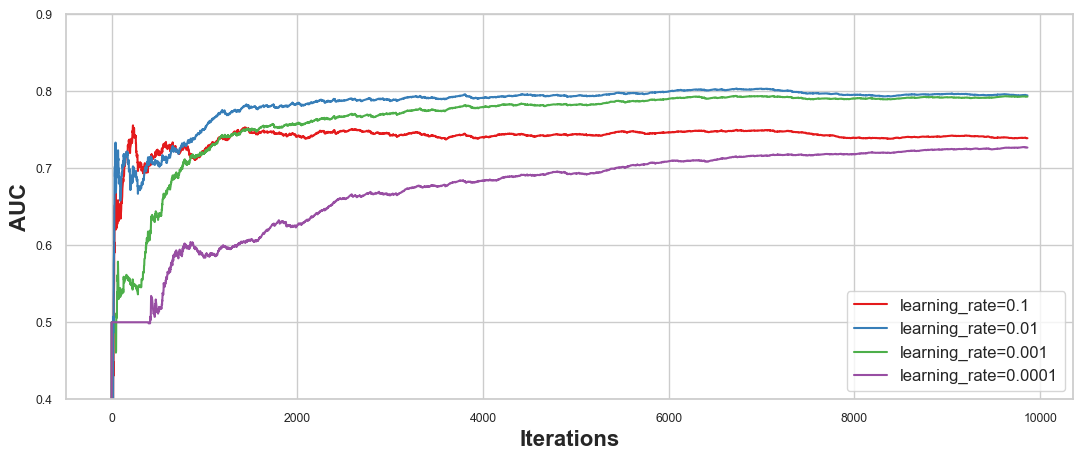

In [118]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
#plt.plot(x, SGD_0005, label='C=0.0005')

plt.plot(x, SGD_1[0], label='learning_rate=0.1')
plt.plot(x, SGD_01[0], label='learning_rate=0.01')
plt.plot(x, SGD_001[0], label='learning_rate=0.001')
plt.plot(x, SGD_0001[0], label='learning_rate=0.0001')
#plt.plot(x, SGD_005, label='C=0.005')

#plt.plot(x, SGD_05, label='C=0.05')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
#plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.4,0.9)
# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot
plt.show()

fig.savefig('SGD_hyperparametes.png')

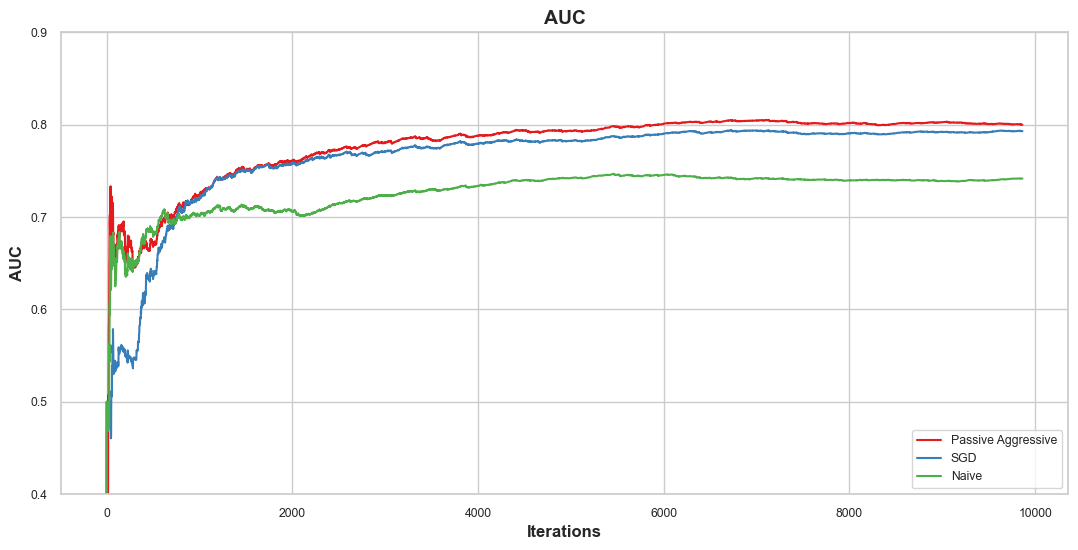

In [119]:
fig = plt.figure(figsize=(13,6))

# Define the x-axis as the number of iterations
x = range(len(passive_aggressive_0001[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001[0], label='Passive Aggressive')
plt.plot(x, SGD_001[0], label='SGD')
plt.plot(x, naive[0], label='Naive')


# Add labels and title
plt.xlabel('Iterations', fontsize=12, fontweight='bold')
plt.ylabel('AUC', fontsize=12, fontweight='bold')
plt.title('AUC', fontsize=14, fontweight='bold')

# Add legend
plt.ylim(0.4,0.9)
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Tree Based Models

Training time: 7.63 seconds
Accuracy Train: 0.8040348742903487
Balanced Accuracy Train: 0.8000310127770127
AUC 0.8000310127770127
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.54%   80.58%   87.42%      8338  
       1      42.81%   79.42%   55.63%      1526  
                                                  
   Macro      69.17%   80.00%   71.53%            
   Micro      80.40%   80.40%   80.40%            
Weighted      87.38%   80.40%   82.51%            

                 80.40% accuracy                  
Accuracy: 0.8665855636658556
Precision: [0.94701987 0.5526839 ]
Recall: [0.89203455 0.72774869]
F1 Score: [0.91870521 0.62824859]
Specifity: 0.8920345489443378
Balanced Accuracy: 0.8098916200219071
AUC: 0.8098916200219071
Confusion matrix:
[[1859  225]
 [ 104  278]]


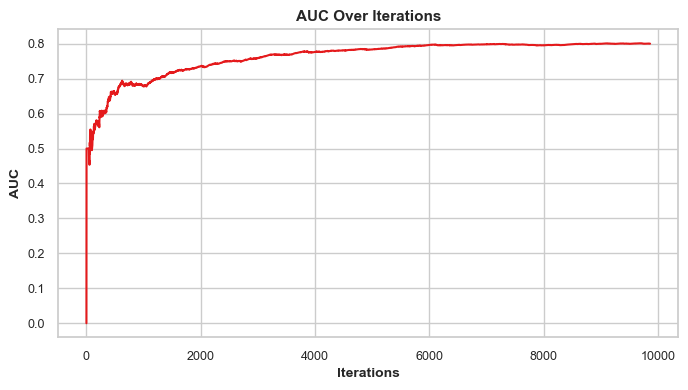

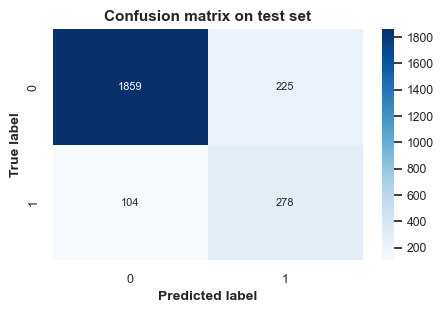

In [120]:
HoeffdingTree=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 13.19 seconds
Accuracy Train: 0.8065693430656934
Balanced Accuracy Train: 0.8058131745043222
AUC 0.805813174504322
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.76%   80.69%   87.58%      8338  
       1      43.27%   80.47%   56.28%      1526  
                                                  
   Macro      69.51%   80.58%   71.93%            
   Micro      80.66%   80.66%   80.66%            
Weighted      87.64%   80.66%   82.74%            

                 80.66% accuracy                  
Accuracy: 0.8223844282238443
Precision: [0.96655329 0.46011396]
Recall: [0.8181382  0.84554974]
F1 Score: [0.88617464 0.59594096]
Specifity: 0.8181381957773513
Balanced Accuracy: 0.8318439669986233
AUC: 0.8318439669986233
Confusion matrix:
[[1705  379]
 [  59  323]]


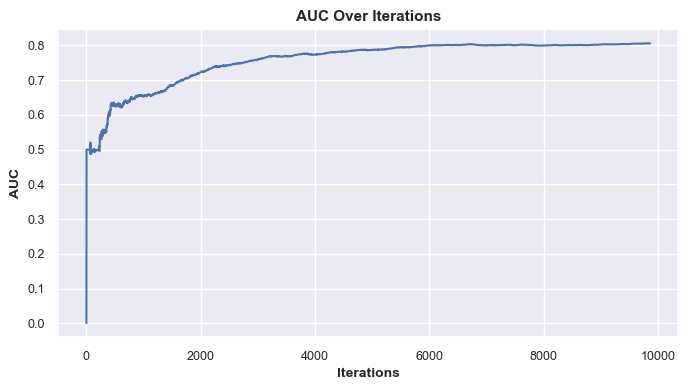

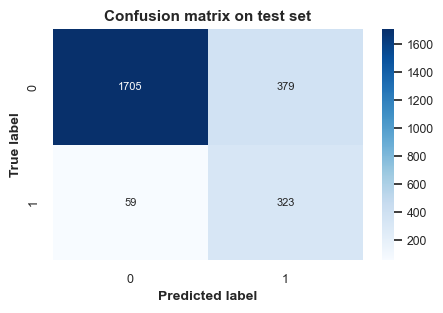

In [121]:
HoeffdingTree_adaptive=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingAdaptiveTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 57.65 seconds
Accuracy Train: 0.8208637469586375
Balanced Accuracy Train: 0.8094500631415739
AUC 0.8094500631415738
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.61%   82.60%   88.63%      8338  
       1      45.47%   79.29%   57.80%      1526  
                                                  
   Macro      70.54%   80.95%   73.21%            
   Micro      82.09%   82.09%   82.09%            
Weighted      87.86%   82.09%   83.86%            

                 82.09% accuracy                  
Accuracy: 0.8402270884022709
Precision: [0.95042644 0.48983051]
Recall: [0.85556622 0.7565445 ]
F1 Score: [0.90050505 0.59465021]
Specifity: 0.8555662188099808
Balanced Accuracy: 0.806055360713891
AUC: 0.806055360713891
Confusion matrix:
[[1783  301]
 [  93  289]]


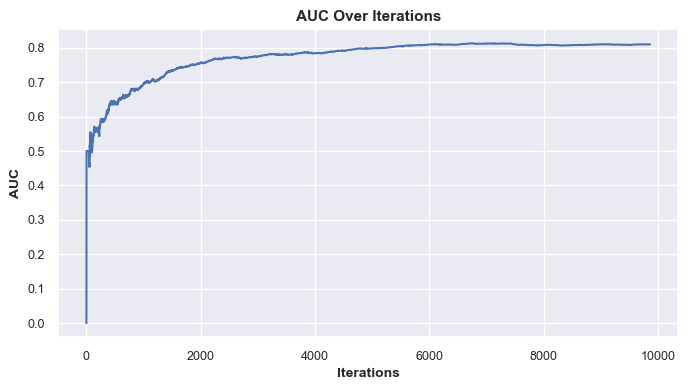

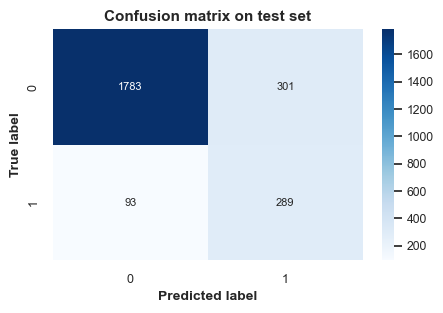

In [122]:
Extremely_fast=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

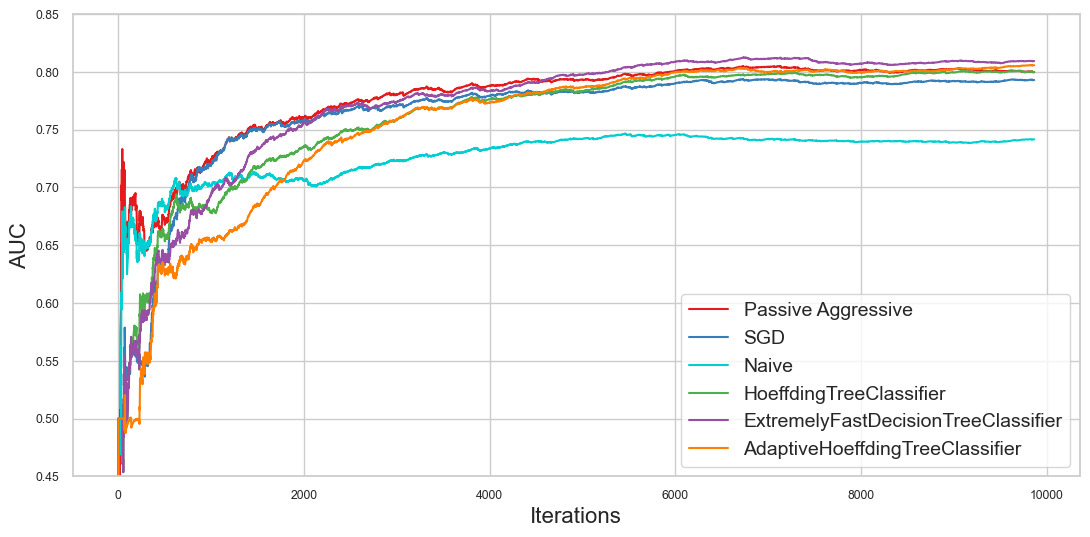

In [131]:
fig = plt.figure(figsize=(13,6))
sns.set_palette('Set1')

sns.set_style("whitegrid")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001[0], label='Passive Aggressive')
plt.plot(x, SGD_001[0], label='SGD') # learning rate=0.001
plt.plot(x, naive[0], label='Naive',color='darkturquoise')
plt.plot(x, HoeffdingTree[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, HoeffdingTree_adaptive[0], label='AdaptiveHoeffdingTreeClassifier')

#plt.plot(x, passive_aggressive_0005, label='C=0.005')
#.plot(x, passive_aggressive_00001, label='C=0.0001',color='lightblue')


# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.45,0.85)
# Add legend
plt.legend(loc='lower right',fontsize=14)

# Show the plot
plt.show()

fig.savefig('auc_oversampling_dataset_final_new_kanoniko.png')

## Feature Selection

In [8]:
df_9_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Administrative_Duration',
 'Month',
 'TrafficType',
 'Administrative','Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_9_features, test_size=0.2, random_state=42,stratify=df_9_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 9), label shape: (9864,)
Test set shape: (2466, 9), label shape: (2466,)


In [9]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

### Linear Models with 9 features

Training time: 2.61 seconds
Accuracy Train: 0.8390105433901054
Balanced Accuracy Train: 0.7934152942504229
AUC 0.793415294250423
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.51%   85.94%   90.03%      8338  
       1      48.64%   72.74%   58.30%      1526  
                                                  
   Macro      71.58%   79.34%   74.16%            
   Micro      83.90%   83.90%   83.90%            
Weighted      87.42%   83.90%   85.12%            

                 83.90% accuracy                  
Accuracy: 0.8365774533657745
Precision: [0.94494442 0.48180243]
Recall: [0.85652591 0.72774869]
F1 Score: [0.89856532 0.57977059]
Specifity: 0.8565259117082533
Balanced Accuracy: 0.7921373014038648
AUC: 0.7921373014038648
Confusion matrix:
[[1785  299]
 [ 104  278]]


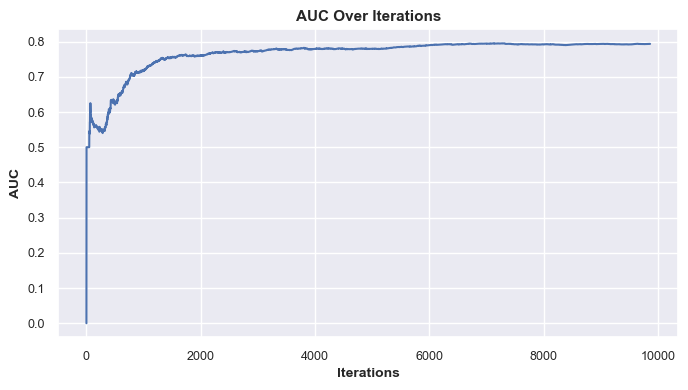

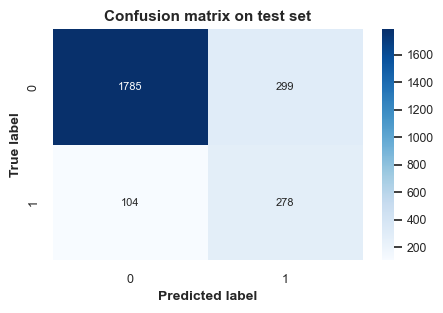

In [10]:
SGD_001_9=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 2.84 seconds
Accuracy Train: 0.8449918896999189
Balanced Accuracy Train: 0.8031101272671315
AUC 0.8031101272671315
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.83%   86.38%   90.40%      8338  
       1      49.93%   74.25%   59.71%      1526  
                                                  
   Macro      72.38%   80.31%   75.06%            
   Micro      84.50%   84.50%   84.50%            
Weighted      87.88%   84.50%   85.66%            

                 84.50% accuracy                  
Accuracy: 0.8637469586374696
Precision: [0.94320487 0.5465587 ]
Recall: [0.8925144  0.70680628]
F1 Score: [0.91715976 0.61643836]
Specifity: 0.8925143953934741
Balanced Accuracy: 0.7996603390579936
AUC: 0.7996603390579937
Confusion matrix:
[[1860  224]
 [ 112  270]]


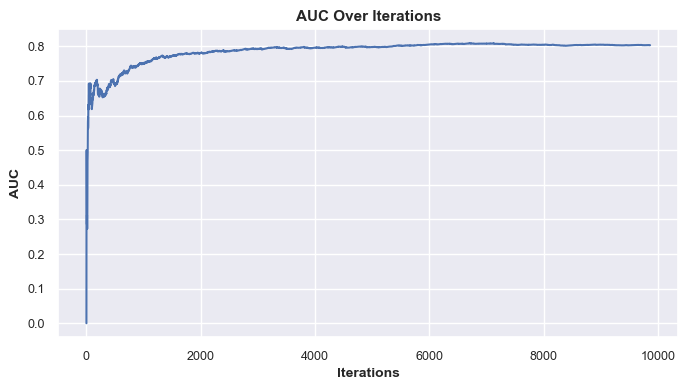

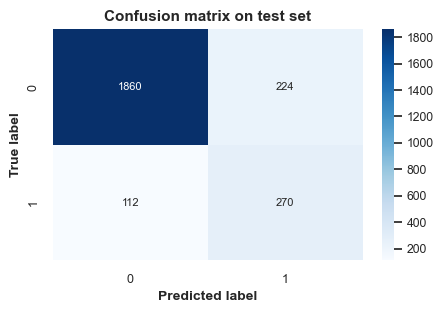

In [135]:
passive_aggressive_0001_9=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 6.35 seconds
Accuracy Train: 0.6885644768856448
Balanced Accuracy Train: 0.7625133332935129
AUC 0.7625133332935129
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.49%   65.54%   78.06%      8338  
       1      31.60%   86.96%   46.35%      1526  
                                                  
   Macro      64.04%   76.25%   62.21%            
   Micro      68.86%   68.86%   68.86%            
Weighted      86.45%   68.86%   73.15%            

                 68.86% accuracy                  
Accuracy: 0.6618004866180048
Precision: [0.95028818 0.2903525 ]
Recall: [0.63291747 0.81937173]
F1 Score: [0.75979263 0.42876712]
Specifity: 0.6329174664107485
Balanced Accuracy: 0.7261445970797198
AUC: 0.7261445970797199
Confusion matrix:
[[1319  765]
 [  69  313]]


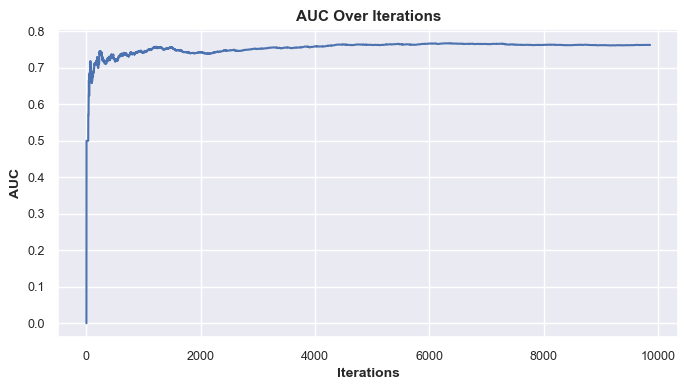

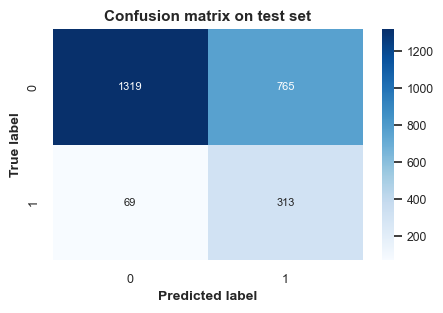

In [136]:
naive_9=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

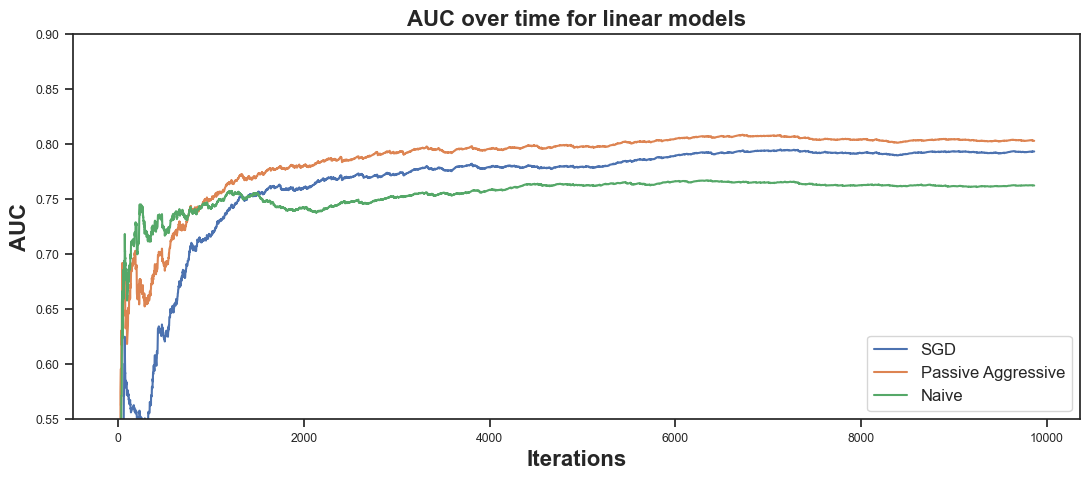

In [138]:
fig = plt.figure(figsize=(13,5))
sns.set_style("whitegrid")
# Set the style to ticks
sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(SGD_001_9[0]))

# Plot the accuracy lists for each model
plt.plot(x, SGD_001_9[0], label='SGD')
plt.plot(x, passive_aggressive_0001_9[0], label='Passive Aggressive')
plt.plot(x, naive_9[0], label='Naive')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC over time for linear models', fontsize=16, fontweight='bold')
plt.ylim(0.55,0.9)
# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot
plt.show()

### Tree-Based with 9 features

Training time: 5.59 seconds
Accuracy Train: 0.8516828872668288
Balanced Accuracy Train: 0.8306244178227427
AUC 0.8306244178227427
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.93%   86.11%   90.75%      8338  
       1      51.32%   80.01%   62.54%      1526  
                                                  
   Macro      73.62%   83.06%   76.64%            
   Micro      85.17%   85.17%   85.17%            
Weighted      89.03%   85.17%   86.39%            

                 85.17% accuracy                  
Accuracy: 0.8690186536901865
Precision: [0.95550957 0.55534709]
Recall: [0.88627639 0.77486911]
F1 Score: [0.91959174 0.64699454]
Specifity: 0.8862763915547025
Balanced Accuracy: 0.8305727507511733
AUC: 0.8305727507511733
Confusion matrix:
[[1847  237]
 [  86  296]]


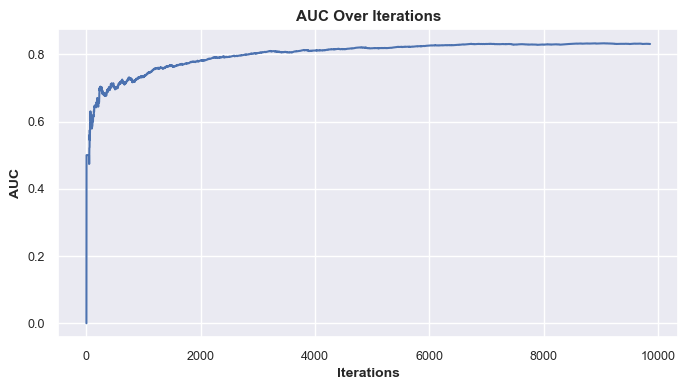

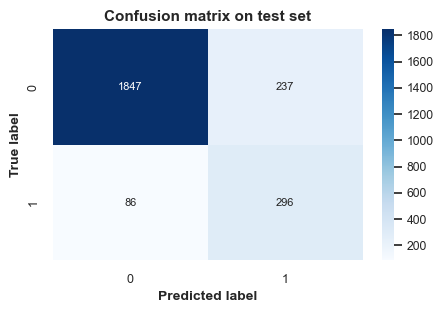

In [142]:
HoeffdingTree_9=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 10.28 seconds
Accuracy Train: 0.8348540145985401
Balanced Accuracy Train: 0.821740742615328
AUC 0.8217407426153279
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.88%   84.07%   89.59%      8338  
       1      47.98%   80.28%   60.06%      1526  
                                                  
   Macro      71.93%   82.17%   74.83%            
   Micro      83.49%   83.49%   83.49%            
Weighted      88.47%   83.49%   85.02%            

                 83.49% accuracy                  
Accuracy: 0.7802108678021087
Precision: [0.96783981 0.40220049]
Recall: [0.76535509 0.86125654]
F1 Score: [0.85476956 0.54833333]
Specifity: 0.7653550863723608
Balanced Accuracy: 0.8133058154374893
AUC: 0.8133058154374893
Confusion matrix:
[[1595  489]
 [  53  329]]


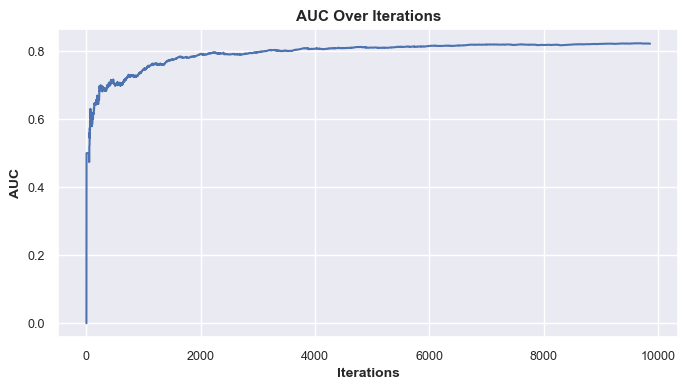

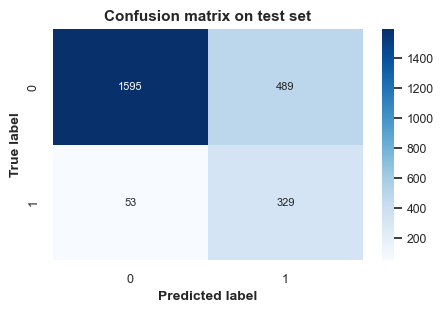

In [200]:
HoeffdingTree_adaptive_9=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingAdaptiveTreeClassifier(seed=42),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

#HoeffdingTree_adaptive_9=train_evaluate_model((
#    imblearn.RandomOverSampler(''
#        classifier=tree.HoeffdingAdaptiveTreeClassifier(),
#        desired_dist={0: .5, 1: .5},
#        seed=42
#    )
#))

Training time: 41.76 seconds
Accuracy Train: 0.8301905920519059
Balanced Accuracy Train: 0.8165730991431168
AUC 0.8165730991431167
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.74%   83.63%   89.28%      8338  
       1      47.11%   79.69%   59.22%      1526  
                                                  
   Macro      71.43%   81.66%   74.25%            
   Micro      83.02%   83.02%   83.02%            
Weighted      88.22%   83.02%   84.63%            

                 83.02% accuracy                  
Accuracy: 0.8694241686942417
Precision: [0.95365602 0.55725191]
Recall: [0.88867562 0.76439791]
F1 Score: [0.92001987 0.64459161]
Specifity: 0.8886756238003839
Balanced Accuracy: 0.8265367647797731
AUC: 0.8265367647797731
Confusion matrix:
[[1852  232]
 [  90  292]]


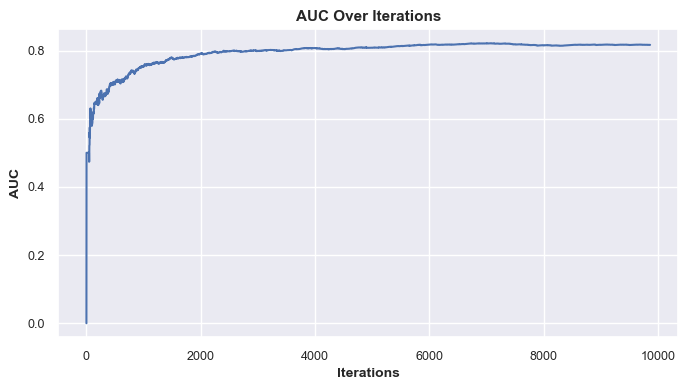

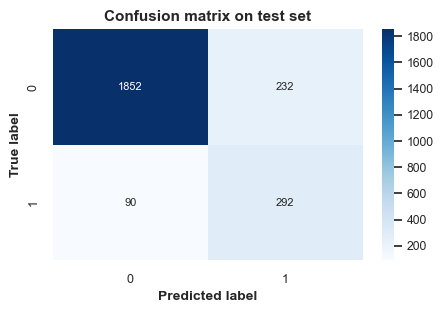

In [144]:
Extremely_fast_9=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

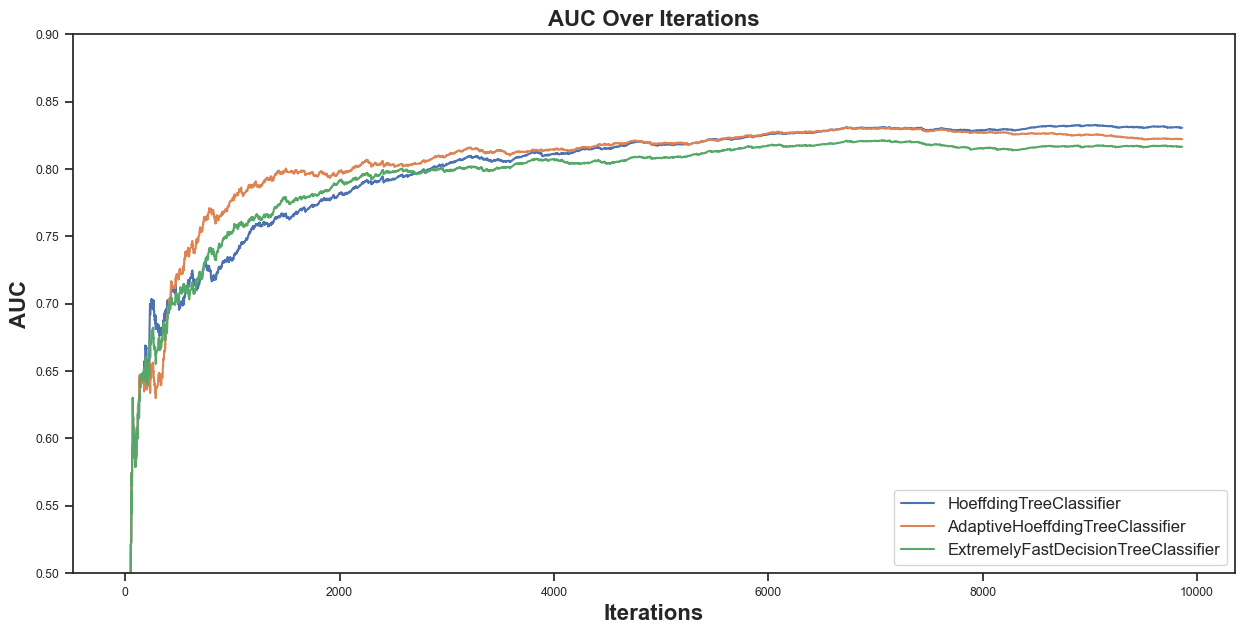

In [145]:
fig = plt.figure(figsize=(15,7))

sns.set_style("whitegrid")
# Set the style to ticks
sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_without_oversampling[0]))

# Plot the accuracy lists for each model
plt.plot(x, HoeffdingTree_9[0], label='HoeffdingTreeClassifier')
#plt.plot(x, passive_aggressive_05, label='C=0.5')
plt.plot(x, HoeffdingTree_adaptive_9[0], label='AdaptiveHoeffdingTreeClassifier')
#plt.plot(x, passive_aggressive_005, label='C=0.05')
plt.plot(x, Extremely_fast_9[0], label='ExtremelyFastDecisionTreeClassifier')

#plt.plot(x, passive_aggressive_0005, label='C=0.005')
#.plot(x, passive_aggressive_00001, label='C=0.0001',color='lightblue')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC Over Iterations', fontsize=16, fontweight='bold')
plt.ylim(0.5,0.9)
# Add legend
plt.legend(loc='lower right',fontsize=12)

# Show the plot
plt.show()

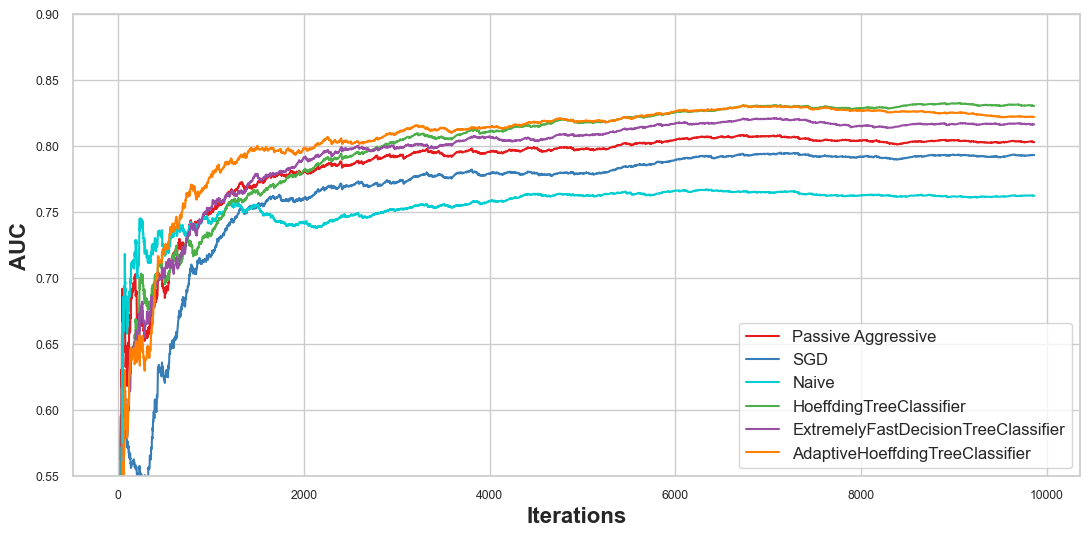

In [149]:
fig = plt.figure(figsize=(13,6))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_9[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001_9[0], label='Passive Aggressive')
plt.plot(x, SGD_001_9[0], label='SGD')
plt.plot(x, naive_9[0], label='Naive',color='darkturquoise')
plt.plot(x, HoeffdingTree_9[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_9[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, HoeffdingTree_adaptive_9[0], label='AdaptiveHoeffdingTreeClassifier')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.55,0.9)
# Show the plot
plt.show()

fig.savefig('AUC_with_top_9.png')

### Linear with 7 features

In [8]:
df_7_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Administrative_Duration',
 'Month',
 'Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_7_features, test_size=0.2, random_state=42,stratify=df_7_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 7), label shape: (9864,)
Test set shape: (2466, 7), label shape: (2466,)


In [9]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

Training time: 2.55 seconds
Accuracy Train: 0.842051905920519
Balanced Accuracy Train: 0.7960173495503069
AUC 0.7960173495503068
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.57%   86.27%   90.23%      8338  
       1      49.29%   72.94%   58.83%      1526  
                                                  
   Macro      71.93%   79.60%   74.53%            
   Micro      84.21%   84.21%   84.21%            
Weighted      87.57%   84.21%   85.37%            

                 84.21% accuracy                  
Accuracy: 0.8410381184103812
Precision: [0.94714588 0.4912892 ]
Recall: [0.85988484 0.7382199 ]
F1 Score: [0.90140845 0.58995816]
Specifity: 0.8598848368522073
Balanced Accuracy: 0.7990523660700827
AUC: 0.7990523660700827
Confusion matrix:
[[1792  292]
 [ 100  282]]


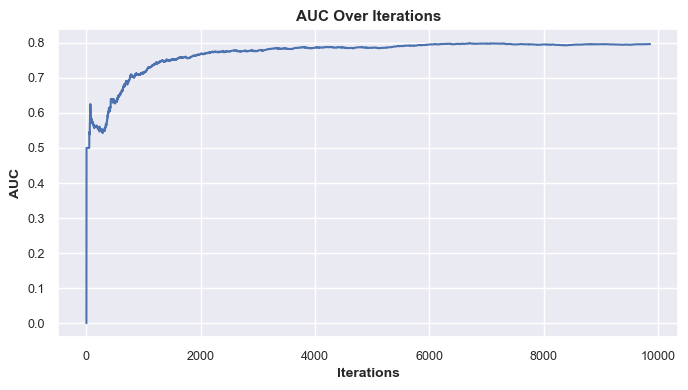

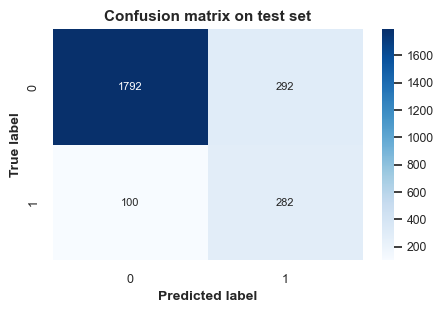

In [13]:
SGD_001_7=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 2.63 seconds
Accuracy Train: 0.8457015409570154
Balanced Accuracy Train: 0.8056713928273561
AUC 0.8056713928273562
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.92%   86.36%   90.44%      8338  
       1      50.09%   74.77%   59.99%      1526  
                                                  
   Macro      72.51%   80.57%   75.22%            
   Micro      84.57%   84.57%   84.57%            
Weighted      87.99%   84.57%   85.73%            

                 84.57% accuracy                  
Accuracy: 0.8600973236009732
Precision: [0.94339623 0.53663366]
Recall: [0.88771593 0.70942408]
F1 Score: [0.91470952 0.61104848]
Specifity: 0.8877159309021113
Balanced Accuracy: 0.7985700073358724
AUC: 0.7985700073358725
Confusion matrix:
[[1850  234]
 [ 111  271]]


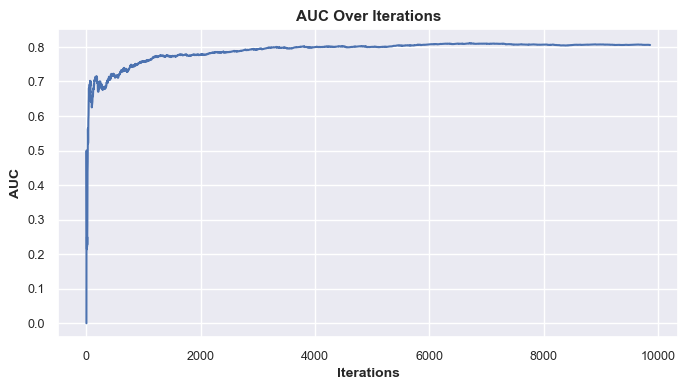

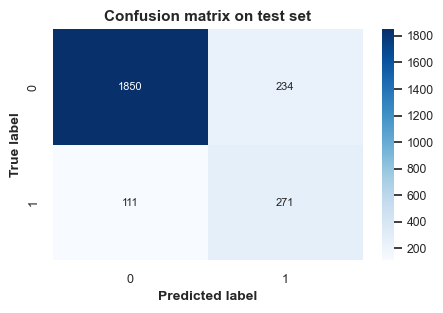

In [154]:
passive_aggressive_0001_7=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 3.62 seconds
Accuracy Train: 0.662712895377129
Balanced Accuracy Train: 0.7573940244839037
AUC 0.7573940244839036
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.98%   62.03%   75.66%      8338  
       1      30.13%   89.45%   45.07%      1526  
                                                  
   Macro      63.55%   75.74%   60.37%            
   Micro      66.27%   66.27%   66.27%            
Weighted      86.64%   66.27%   70.93%            

                 66.27% accuracy                  
Accuracy: 0.637875101378751
Precision: [0.95772483 0.2806867 ]
Recall: [0.59788868 0.85602094]
F1 Score: [0.73618907 0.42275372]
Specifity: 0.5978886756238004
Balanced Accuracy: 0.7269548090160887
AUC: 0.7269548090160889
Confusion matrix:
[[1246  838]
 [  55  327]]


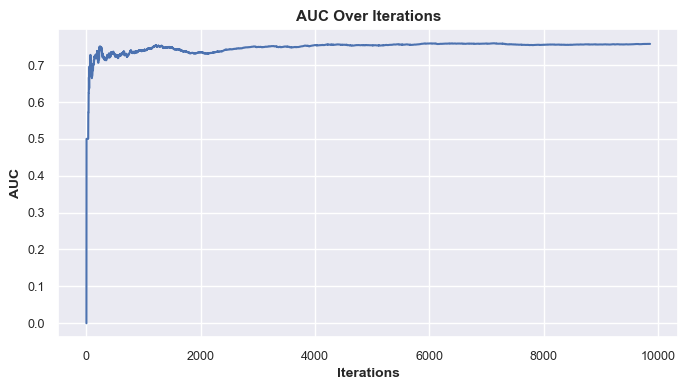

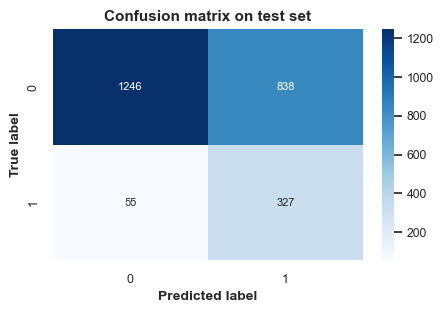

In [155]:
naive_7=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

#### Tree with 7

Training time: 5.44 seconds
Accuracy Train: 0.847323600973236
Balanced Accuracy Train: 0.8304550500212673
AUC 0.8304550500212673
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.01%   85.49%   90.45%      8338  
       1      50.41%   80.60%   62.03%      1526  
                                                  
   Macro      73.21%   83.05%   76.24%            
   Micro      84.73%   84.73%   84.73%            
Weighted      88.96%   84.73%   86.05%            

                 84.73% accuracy                  
Accuracy: 0.8686131386861314
Precision: [0.95454545 0.55471698]
Recall: [0.88675624 0.76963351]
F1 Score: [0.91940299 0.64473684]
Specifity: 0.8867562380038387
Balanced Accuracy: 0.8281948729286209
AUC: 0.8281948729286209
Confusion matrix:
[[1848  236]
 [  88  294]]


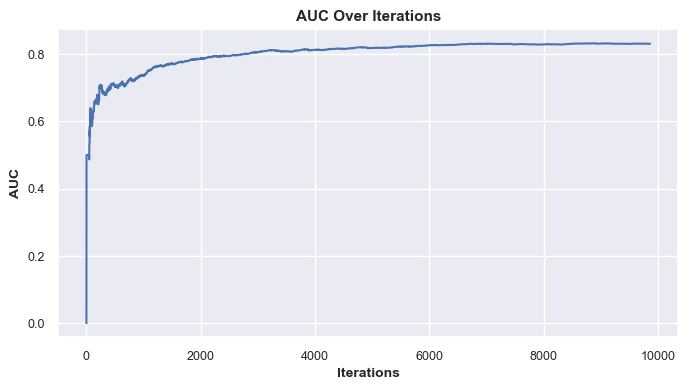

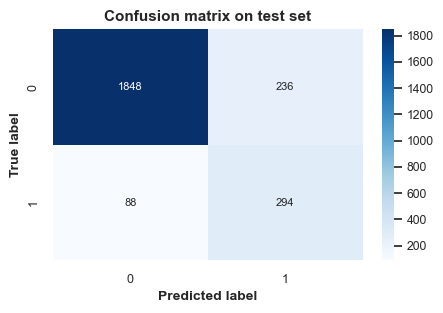

In [156]:
HoeffdingTree_7=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 9.13 seconds
Accuracy Train: 0.8374898621248986
Balanced Accuracy Train: 0.8222291191899771
AUC 0.8222291191899772
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.85%   84.43%   89.78%      8338  
       1      48.47%   80.01%   60.37%      1526  
                                                  
   Macro      72.16%   82.22%   75.07%            
   Micro      83.75%   83.75%   83.75%            
Weighted      88.52%   83.75%   85.23%            

                 83.75% accuracy                  
Accuracy: 0.8600973236009732
Precision: [0.96176314 0.53173242]
Recall: [0.86900192 0.81151832]
F1 Score: [0.91303252 0.64248705]
Specifity: 0.8690019193857965
Balanced Accuracy: 0.8402601219965632
AUC: 0.8402601219965632
Confusion matrix:
[[1811  273]
 [  72  310]]


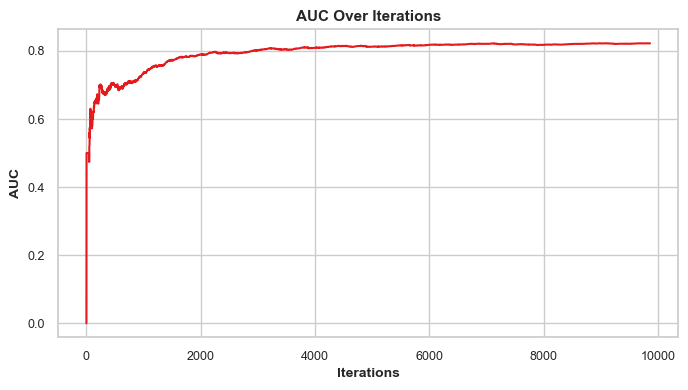

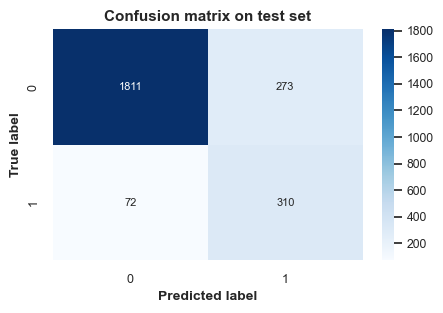

In [196]:
HoeffdingTree_adaptive_7=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingAdaptiveTreeClassifier(seed=42),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 41.03 seconds
Accuracy Train: 0.8307988645579887
Balanced Accuracy Train: 0.8212158989131224
AUC 0.8212158989131224
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.95%   83.51%   89.30%      8338  
       1      47.26%   80.73%   59.62%      1526  
                                                  
   Macro      71.60%   82.12%   74.46%            
   Micro      83.08%   83.08%   83.08%            
Weighted      88.42%   83.08%   84.71%            

                 83.08% accuracy                  
Accuracy: 0.8394160583941606
Precision: [0.96681416 0.4893617 ]
Recall: [0.83877159 0.84293194]
F1 Score: [0.89825283 0.61923077]
Specifity: 0.8387715930902111
Balanced Accuracy: 0.840851765131493
AUC: 0.840851765131493
Confusion matrix:
[[1748  336]
 [  60  322]]


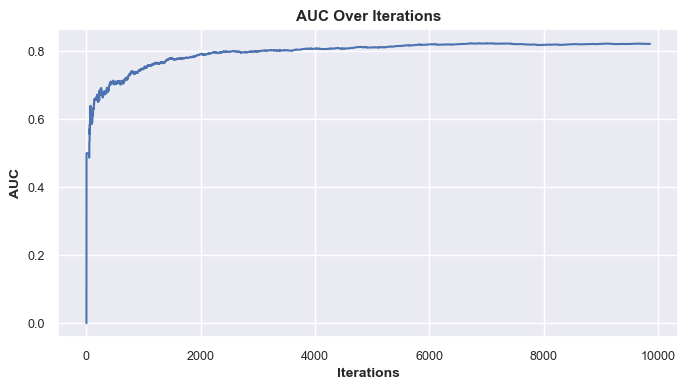

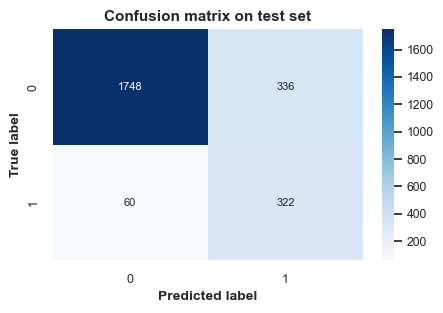

In [158]:
Extremely_fast_7=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

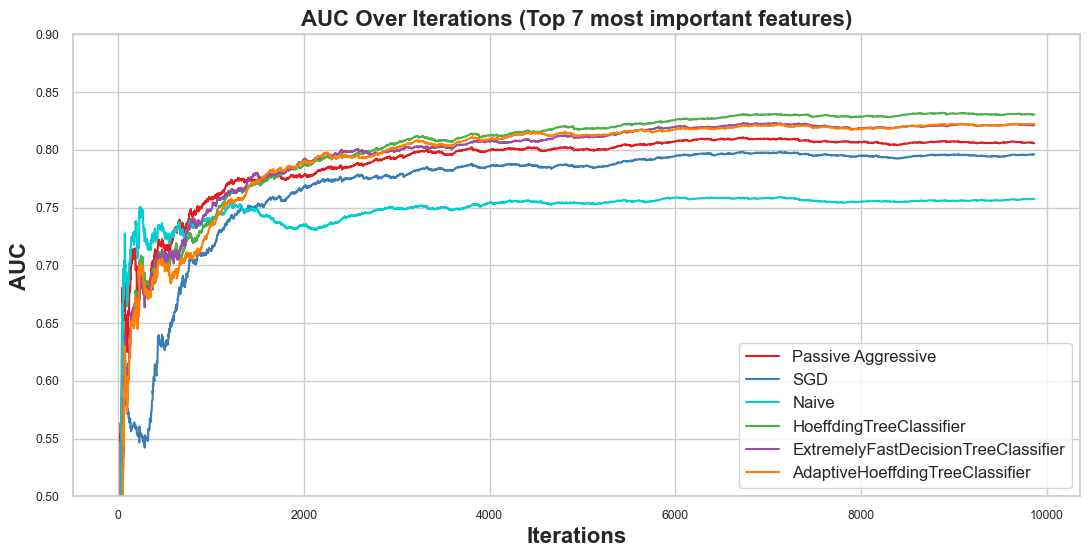

In [160]:
fig = plt.figure(figsize=(13,6))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_7[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001_7[0], label='Passive Aggressive')
plt.plot(x, SGD_001_7[0], label='SGD')
plt.plot(x, naive_7[0], label='Naive',color='darkturquoise')
plt.plot(x, HoeffdingTree_7[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_7[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, HoeffdingTree_adaptive_7[0], label='AdaptiveHoeffdingTreeClassifier')

# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC Over Iterations (Top 7 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.5,0.9)
# Show the plot
plt.show()

fig.savefig('AUC_with_top_7.png')

In [14]:
df_5_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Revenue']]

# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_5_features, test_size=0.2, random_state=42,stratify=df['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 5), label shape: (9864,)
Test set shape: (2466, 5), label shape: (2466,)


In [15]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

### Linear with 5 features

Training time: 2.38 seconds
Accuracy Train: 0.8513787510137875
Balanced Accuracy Train: 0.7993927594518235
AUC 0.7993927594518236
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.54%   87.47%   90.87%      8338  
       1      51.40%   72.41%   60.12%      1526  
                                                  
   Macro      72.97%   79.94%   75.49%            
   Micro      85.14%   85.14%   85.14%            
Weighted      87.87%   85.14%   86.11%            

                 85.14% accuracy                  
Accuracy: 0.8495539334955393
Precision: [0.94725849 0.50998185]
Recall: [0.87044146 0.73560209]
F1 Score: [0.90722681 0.60235798]
Specifity: 0.8704414587332053
Balanced Accuracy: 0.8030217764870216
AUC: 0.8030217764870216
Confusion matrix:
[[1814  270]
 [ 101  281]]


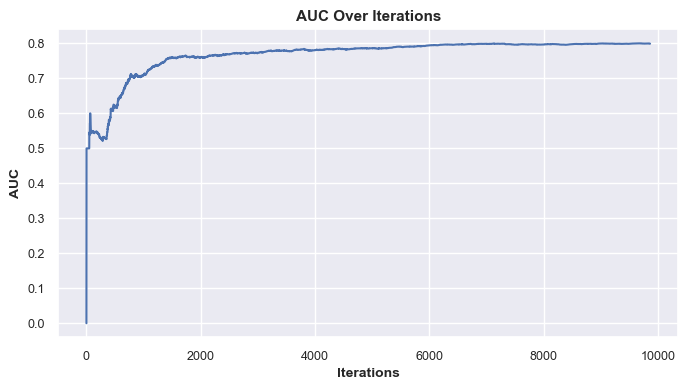

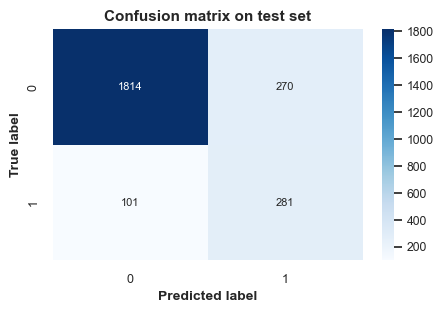

In [16]:
SGD_001_5=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 2.98 seconds
Accuracy Train: 0.8591849148418491
Balanced Accuracy Train: 0.8107023631641772
AUC 0.8107023631641773
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.88%   88.09%   91.36%      8338  
       1      53.23%   74.05%   61.93%      1526  
                                                  
   Macro      74.06%   81.07%   76.65%            
   Micro      85.92%   85.92%   85.92%            
Weighted      88.44%   85.92%   86.81%            

                 85.92% accuracy                  
Accuracy: 0.862124898621249
Precision: [0.94263959 0.54233871]
Recall: [0.89107486 0.70418848]
F1 Score: [0.91613222 0.61275626]
Specifity: 0.8910748560460653
Balanced Accuracy: 0.797631668860729
AUC: 0.797631668860729
Confusion matrix:
[[1857  227]
 [ 113  269]]


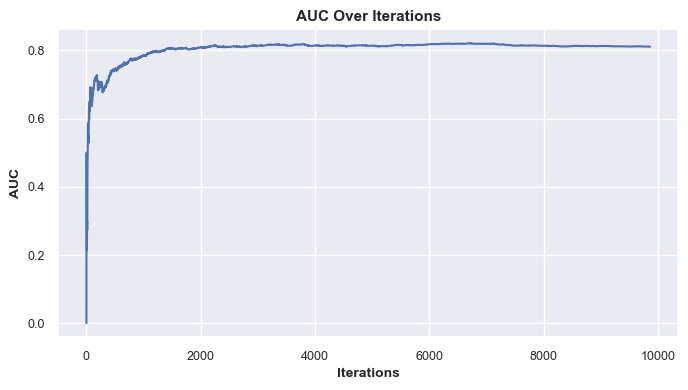

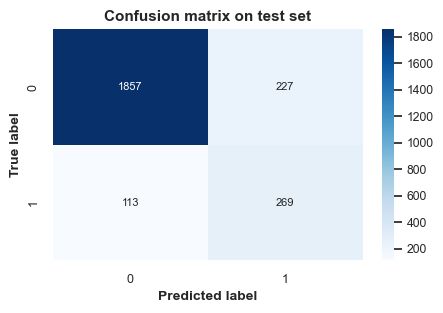

In [164]:
passive_aggressive_0001_5=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 3.77 seconds
Accuracy Train: 0.5448094079480941
Balanced Accuracy Train: 0.6948806440346224
AUC 0.6948806440346224
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.74%   47.76%   63.95%      8338  
       1      24.22%   91.22%   38.27%      1526  
                                                  
   Macro      60.48%   69.49%   51.11%            
   Micro      54.48%   54.48%   54.48%            
Weighted      85.52%   54.48%   59.98%            

                 54.48% accuracy                  
Accuracy: 0.5109489051094891
Precision: [0.95164609 0.22423025]
Recall: [0.44385797 0.87696335]
F1 Score: [0.60536649 0.35714286]
Specifity: 0.44385796545105566
Balanced Accuracy: 0.660410658118198
AUC: 0.660410658118198
Confusion matrix:
[[ 925 1159]
 [  47  335]]


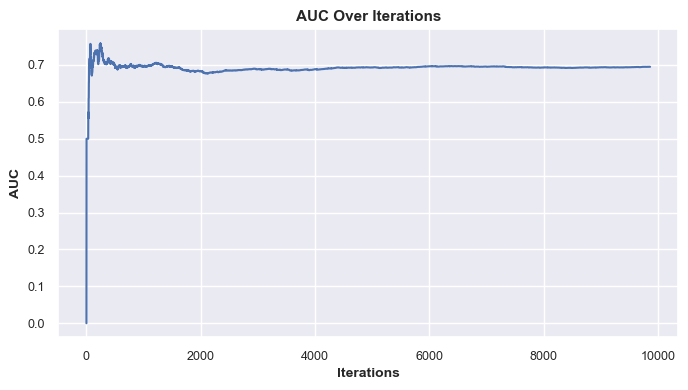

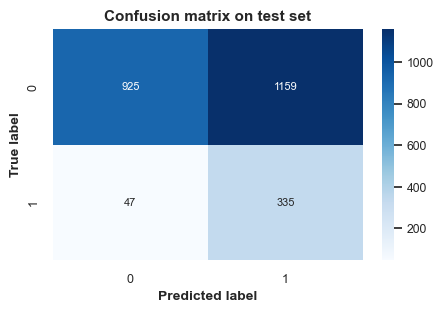

In [165]:
naive_5=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

### Tree-Based with 5 features

Training time: 4.66 seconds
Accuracy Train: 0.8334347120843472
Balanced Accuracy Train: 0.8286641525306772
AUC 0.828664152530677
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.24%   83.56%   89.45%      8338  
       1      47.77%   82.18%   60.42%      1526  
                                                  
   Macro      72.01%   82.87%   74.94%            
   Micro      83.34%   83.34%   83.34%            
Weighted      88.74%   83.34%   84.96%            

                 83.34% accuracy                  
Accuracy: 0.8548256285482563
Precision: [0.95953142 0.52040816]
Recall: [0.8646833  0.80104712]
F1 Score: [0.9096416  0.63092784]
Specifity: 0.8646833013435701
Balanced Accuracy: 0.8328652108812091
AUC: 0.8328652108812092
Confusion matrix:
[[1802  282]
 [  76  306]]


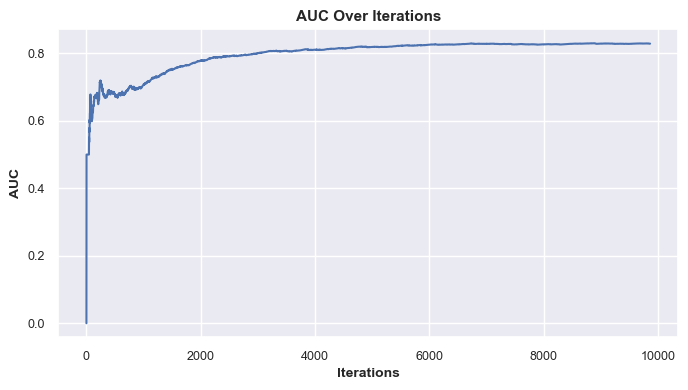

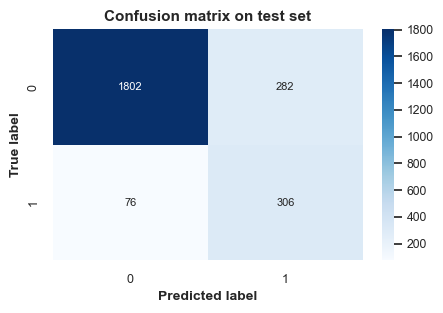

In [203]:
HoeffdingTree_5=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 7.23 seconds
Accuracy Train: 0.8448905109489051
Balanced Accuracy Train: 0.8150961018841244
AUC 0.8150961018841244
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.36%   85.82%   90.34%      8338  
       1      49.92%   77.20%   60.63%      1526  
                                                  
   Macro      72.64%   81.51%   75.49%            
   Micro      84.49%   84.49%   84.49%            
Weighted      88.33%   84.49%   85.75%            

                 84.49% accuracy                  
Accuracy: 0.862124898621249
Precision: [0.9499484  0.53977273]
Recall: [0.88339731 0.7460733 ]
F1 Score: [0.91546494 0.62637363]
Specifity: 0.8833973128598849
Balanced Accuracy: 0.8147353056446021
AUC: 0.8147353056446022
Confusion matrix:
[[1841  243]
 [  97  285]]


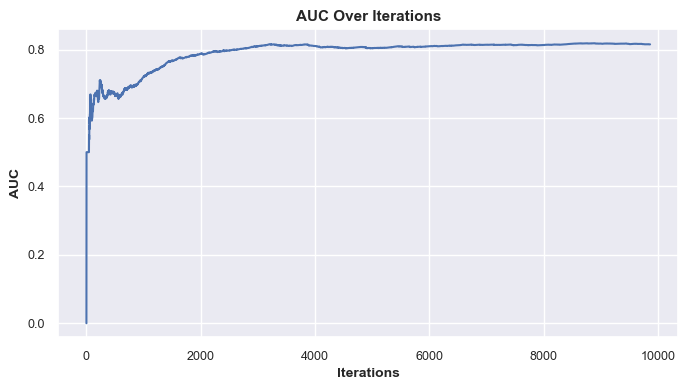

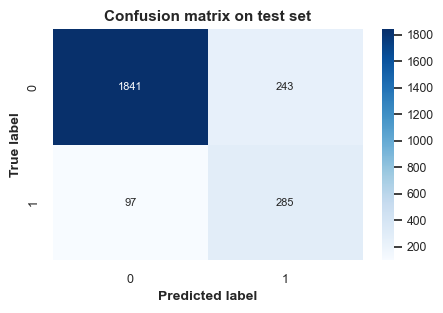

In [167]:
HoeffdingTree_adaptive_5=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingAdaptiveTreeClassifier(seed=42),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 24.81 seconds
Accuracy Train: 0.8533049472830495
Balanced Accuracy Train: 0.8243563159021512
AUC 0.8243563159021512
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.61%   86.63%   90.90%      8338  
       1      51.71%   78.24%   62.27%      1526  
                                                  
   Macro      73.66%   82.44%   76.58%            
   Micro      85.33%   85.33%   85.33%            
Weighted      88.81%   85.33%   86.47%            

                 85.33% accuracy                  
Accuracy: 0.8694241686942417
Precision: [0.95506198 0.55660377]
Recall: [0.88723608 0.77225131]
F1 Score: [0.9199005  0.64692982]
Specifity: 0.8872360844529751
Balanced Accuracy: 0.8297436966767493
AUC: 0.8297436966767493
Confusion matrix:
[[1849  235]
 [  87  295]]


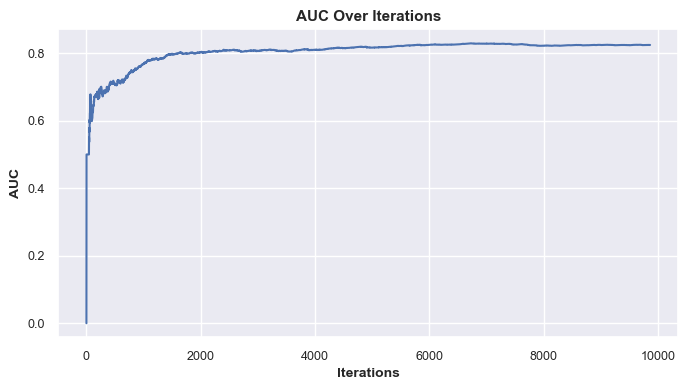

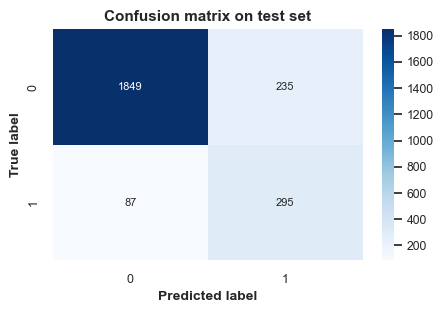

In [168]:
Extremely_fast_5=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

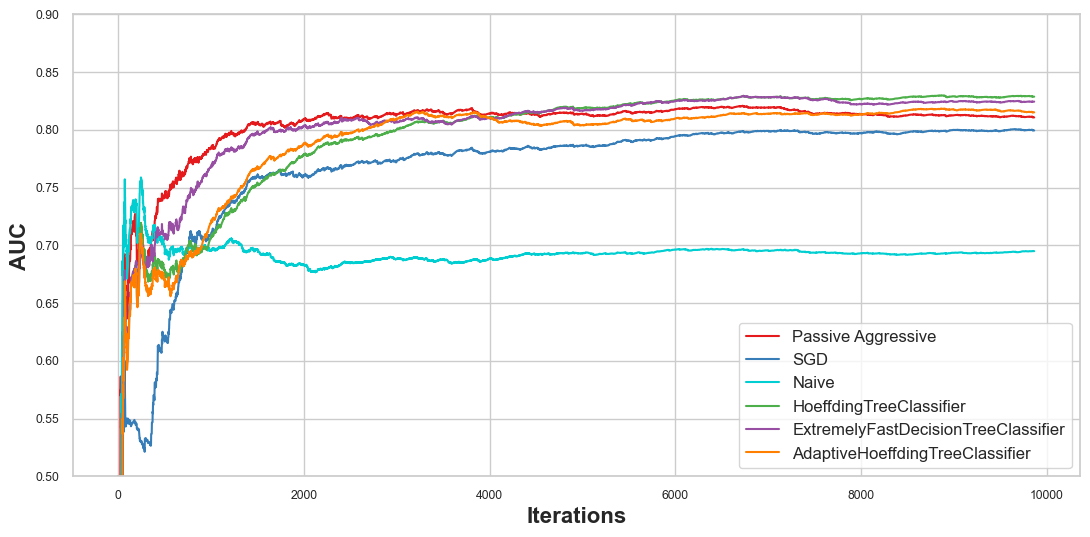

In [169]:
fig = plt.figure(figsize=(13,6))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001_5[0], label='Passive Aggressive')
plt.plot(x, SGD_001_5[0], label='SGD')
plt.plot(x, naive_5[0], label='Naive',color='darkturquoise')
plt.plot(x, HoeffdingTree_5[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_5[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, HoeffdingTree_adaptive_5[0], label='AdaptiveHoeffdingTreeClassifier')


# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.5,0.9)
# Show the plot
plt.show()

fig.savefig('AUC_with_top_5.png')

## Linear Models with 3 features

In [17]:
df_3_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'Revenue']]

# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_3_features, test_size=0.2, random_state=42,stratify=df['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 3), label shape: (9864,)
Test set shape: (2466, 3), label shape: (2466,)


In [18]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

Training time: 2.48 seconds
Accuracy Train: 0.8597931873479319
Balanced Accuracy Train: 0.8024961591626645
AUC 0.8024961591626645
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.52%   88.55%   91.44%      8338  
       1      53.48%   71.95%   61.36%      1526  
                                                  
   Macro      74.00%   80.25%   76.40%            
   Micro      85.98%   85.98%   85.98%            
Weighted      88.17%   85.98%   86.78%            

                 85.98% accuracy                  
Accuracy: 0.8536090835360909
Precision: [0.94753247 0.5194085 ]
Recall: [0.87523992 0.73560209]
F1 Score: [0.90995261 0.60888407]
Specifity: 0.8752399232245681
Balanced Accuracy: 0.805421008732703
AUC: 0.805421008732703
Confusion matrix:
[[1824  260]
 [ 101  281]]


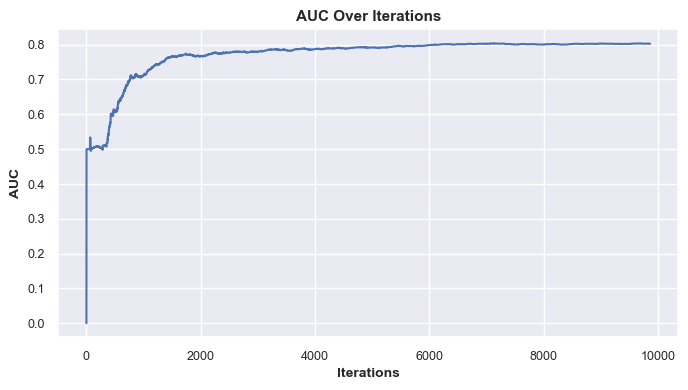

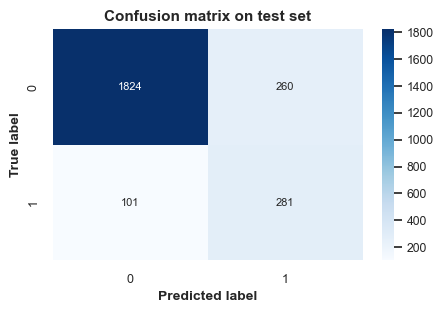

In [19]:
SGD_001_3=train_evaluate_model((
    preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.LogisticRegression(optimizer=optim.SGD(.001)),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 3.33 seconds
Accuracy Train: 0.8672952149229521
Balanced Accuracy Train: 0.7972969213256305
AUC 0.7972969213256305
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.17%   89.87%   91.97%      8338  
       1      55.69%   69.59%   61.87%      1526  
                                                  
   Macro      74.93%   79.73%   76.92%            
   Micro      86.73%   86.73%   86.73%            
Weighted      88.22%   86.73%   87.31%            

                 86.73% accuracy                  
Accuracy: 0.8560421735604218
Precision: [0.93551637 0.52806653]
Recall: [0.89107486 0.66492147]
F1 Score: [0.91275498 0.58864426]
Specifity: 0.8910748560460653
Balanced Accuracy: 0.7779981610073259
AUC: 0.7779981610073259
Confusion matrix:
[[1857  227]
 [ 128  254]]


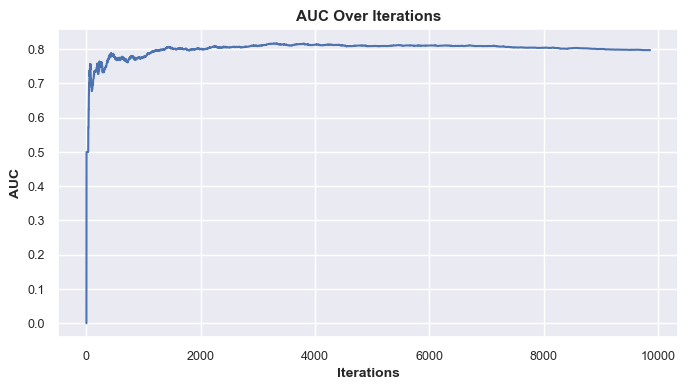

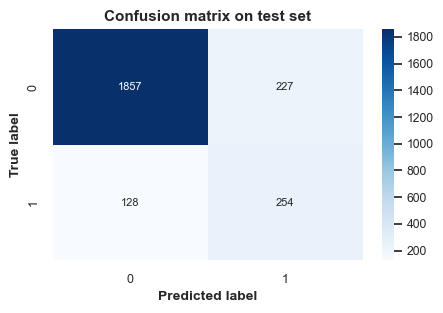

In [173]:
naive_3=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 3.08 seconds
Accuracy Train: 0.866889699918897
Balanced Accuracy Train: 0.8128506227862331
AUC 0.8128506227862333
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.83%   89.11%   91.88%      8338  
       1      55.25%   73.46%   63.07%      1526  
                                                  
   Macro      75.04%   81.29%   77.47%            
   Micro      86.69%   86.69%   86.69%            
Weighted      88.71%   86.69%   87.42%            

                 86.69% accuracy                  
Accuracy: 0.8588807785888077
Precision: [0.93971631 0.53455285]
Recall: [0.89011516 0.68848168]
F1 Score: [0.91424347 0.60183066]
Specifity: 0.8901151631477927
Balanced Accuracy: 0.7892984192702315
AUC: 0.7892984192702315
Confusion matrix:
[[1855  229]
 [ 119  263]]


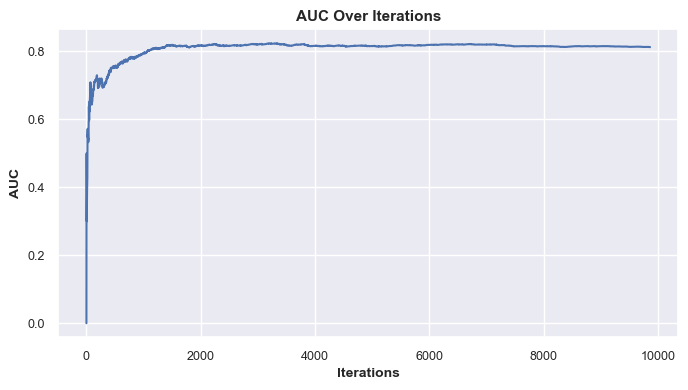

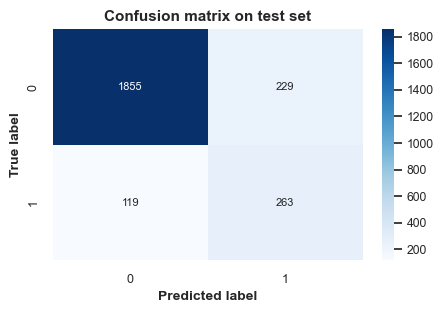

In [174]:
passive_aggressive_0001_3=train_evaluate_model(
(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
        classifier=linear_model.PAClassifier(C=0.001),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

## Tree-Based with 3 features

Training time: 4.65 seconds
Accuracy Train: 0.8647607461476075
Balanced Accuracy Train: 0.8405015864772346
AUC 0.8405015864772345
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.09%   87.56%   91.63%      8338  
       1      54.24%   80.54%   64.82%      1526  
                                                  
   Macro      75.16%   84.05%   78.22%            
   Micro      86.48%   86.48%   86.48%            
Weighted      89.62%   86.48%   87.48%            

                 86.48% accuracy                  
Accuracy: 0.8710462287104623
Precision: [0.95515464 0.5608365 ]
Recall: [0.88915547 0.77225131]
F1 Score: [0.92097416 0.64977974]
Specifity: 0.8891554702495201
Balanced Accuracy: 0.8307033895750218
AUC: 0.8307033895750219
Confusion matrix:
[[1853  231]
 [  87  295]]


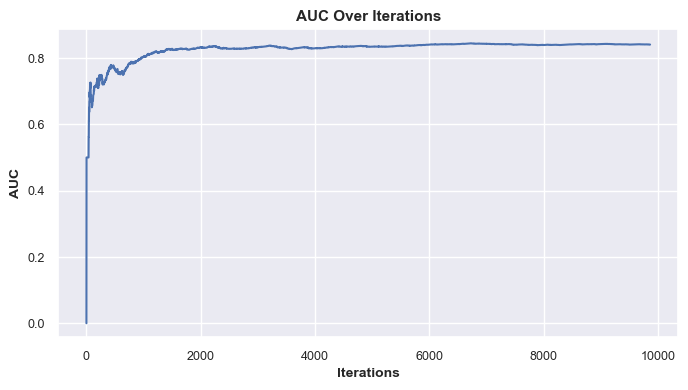

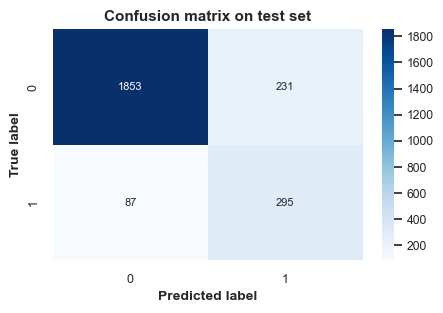

In [206]:
HoeffdingTree_3=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 6.92 seconds
Accuracy Train: 0.8595904298459043
Balanced Accuracy Train: 0.835034110910996
AUC 0.8350341109109959
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.96%   87.06%   91.29%      8338  
       1      53.07%   79.95%   63.79%      1526  
                                                  
   Macro      74.51%   83.50%   77.54%            
   Micro      85.96%   85.96%   85.96%            
Weighted      89.32%   85.96%   87.04%            

                 85.96% accuracy                  
Accuracy: 0.8580697485806975
Precision: [0.9492228  0.52985075]
Recall: [0.87907869 0.7434555 ]
F1 Score: [0.91280518 0.61873638]
Specifity: 0.8790786948176583
Balanced Accuracy: 0.8112670960999286
AUC: 0.8112670960999286
Confusion matrix:
[[1832  252]
 [  98  284]]


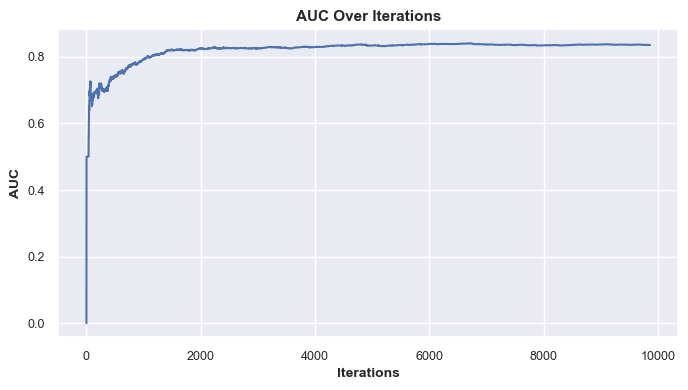

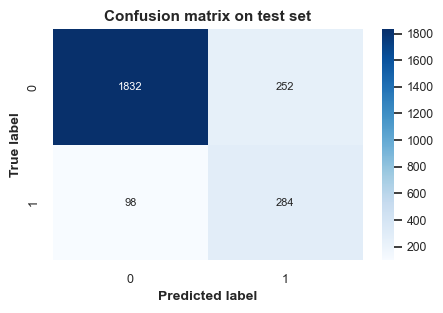

In [176]:
HoeffdingTree_adaptive_3=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.HoeffdingAdaptiveTreeClassifier(seed=42),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

Training time: 11.37 seconds
Accuracy Train: 0.8526966747769668
Balanced Accuracy Train: 0.8304210192750775
AUC 0.8304210192750775
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.89%   86.27%   90.83%      8338  
       1      51.54%   79.82%   62.64%      1526  
                                                  
   Macro      73.72%   83.04%   76.73%            
   Micro      85.27%   85.27%   85.27%            
Weighted      89.03%   85.27%   86.47%            

                 85.27% accuracy                  
Accuracy: 0.8690186536901865
Precision: [0.95503876 0.55555556]
Recall: [0.88675624 0.77225131]
F1 Score: [0.91963175 0.64622125]
Specifity: 0.8867562380038387
Balanced Accuracy: 0.8295037734521811
AUC: 0.8295037734521812
Confusion matrix:
[[1848  236]
 [  87  295]]


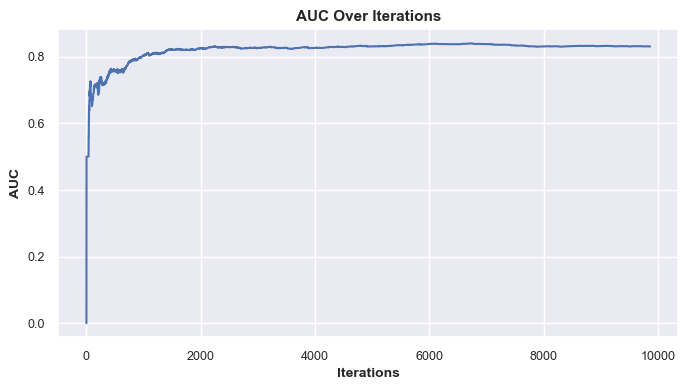

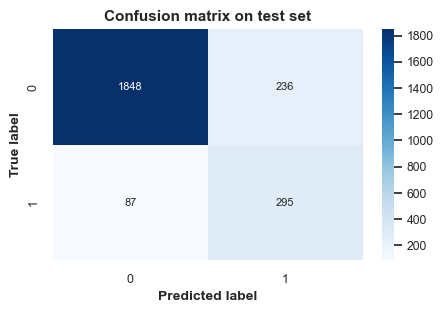

In [177]:
Extremely_fast_3=train_evaluate_model((preprocessing.StandardScaler()|
    imblearn.RandomOverSampler(
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    )
))

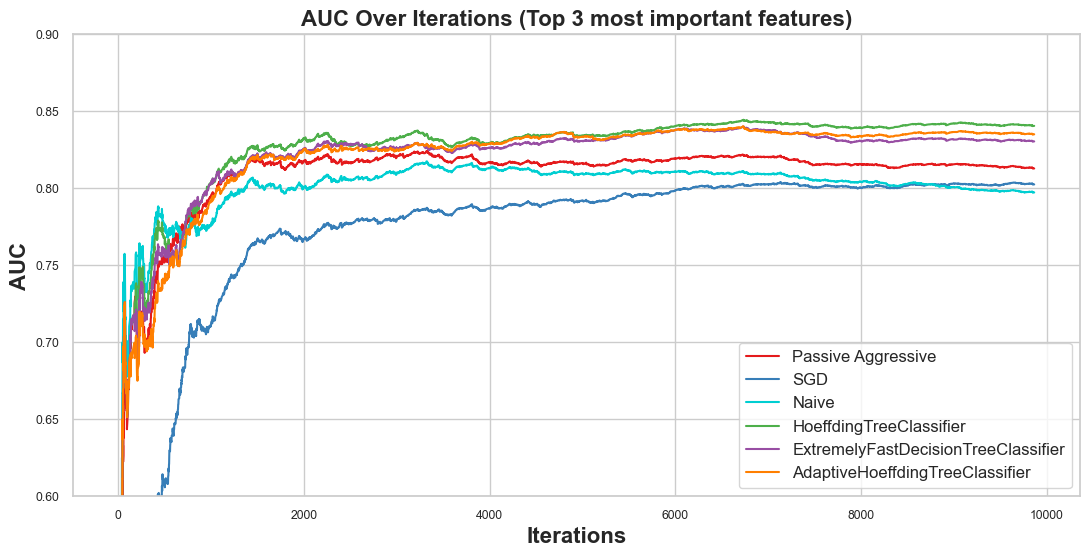

In [178]:
fig = plt.figure(figsize=(13,6))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001_3[0], label='Passive Aggressive')
plt.plot(x, SGD_001_3[0], label='SGD')
plt.plot(x, naive_3[0], label='Naive',color='darkturquoise')
plt.plot(x, HoeffdingTree_3[0], label='HoeffdingTreeClassifier')
plt.plot(x, Extremely_fast_3[0], label='ExtremelyFastDecisionTreeClassifier')
plt.plot(x, HoeffdingTree_adaptive_3[0], label='AdaptiveHoeffdingTreeClassifier')



# Add labels and title
plt.xlabel('Iterations', fontsize=16, fontweight='bold')
plt.ylabel('AUC', fontsize=16, fontweight='bold')
plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.9)
# Show the plot
plt.show()

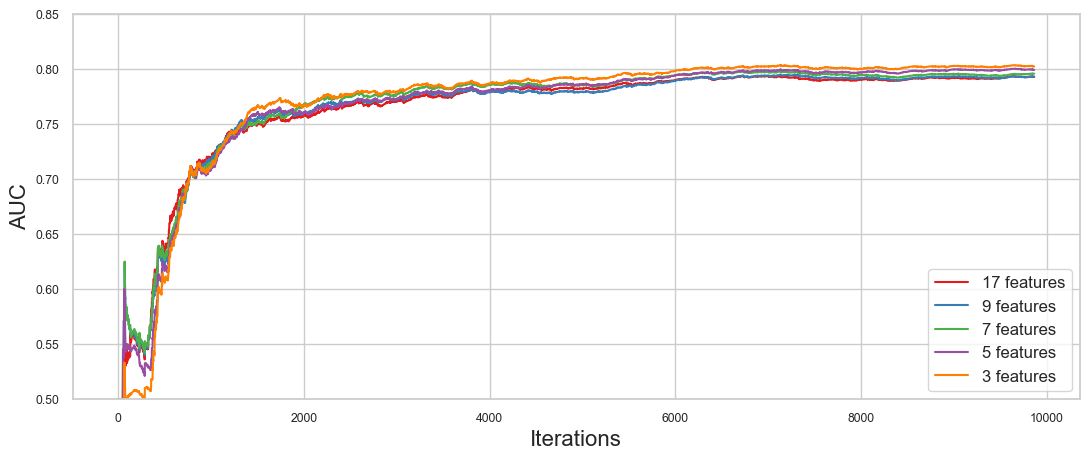

In [32]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len( SGD_001[0]))

# Plot the accuracy lists for each model
plt.plot(x, SGD_001[0], label='17 features')
plt.plot(x, SGD_001_9[0], label='9 features')
plt.plot(x, SGD_001_7[0], label='7 features')
plt.plot(x, SGD_001_5[0], label='5 features')
plt.plot(x, SGD_001_3[0], label='3 features')


# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.5,0.85)
plt.savefig('sgd features.png')
plt.show()

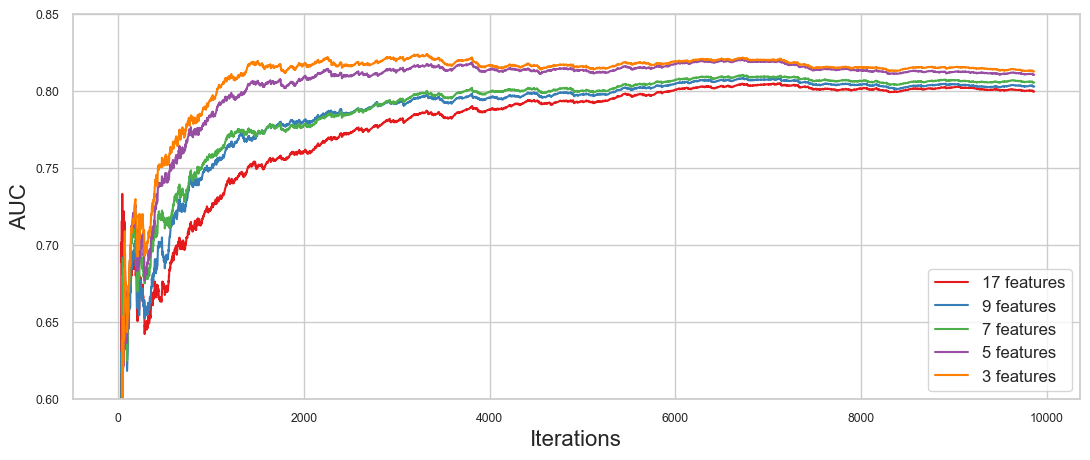

In [208]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, passive_aggressive_0001[0], label='17 features')
plt.plot(x, passive_aggressive_0001_9[0], label='9 features')
plt.plot(x, passive_aggressive_0001_7[0], label='7 features')
plt.plot(x, passive_aggressive_0001_5[0], label='5 features')
plt.plot(x, passive_aggressive_0001_3[0], label='3 features')

# Add labels and title
# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.85)
plt.savefig('pa.png')
plt.show()

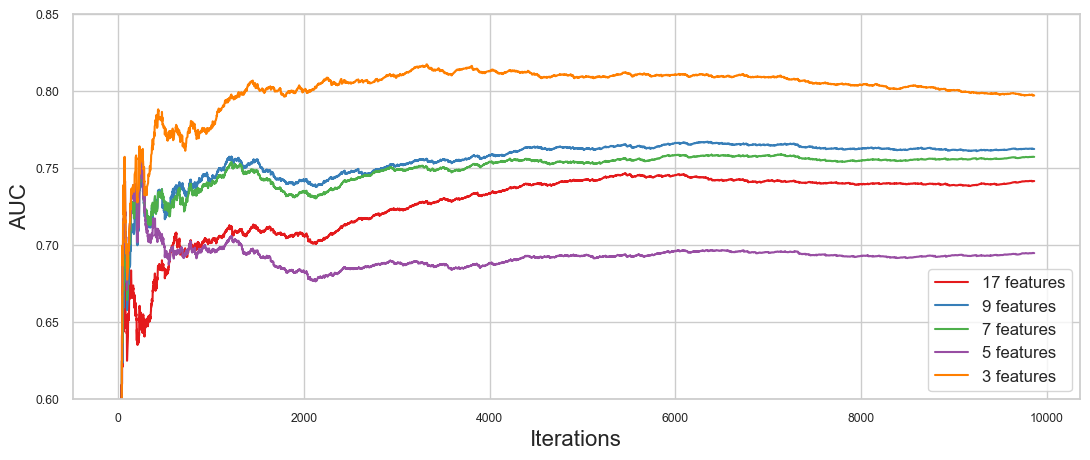

In [209]:
fig = plt.figure(figsize=(13,5))
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, naive[0], label='17 features')
plt.plot(x, naive_9[0], label='9 features')
plt.plot(x, naive_7[0], label='7 features')
plt.plot(x, naive_5[0], label='5 features')
plt.plot(x, naive_3[0], label='3 features')

# Add labels and title
# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.85)
plt.savefig('naive features.png')
plt.show()

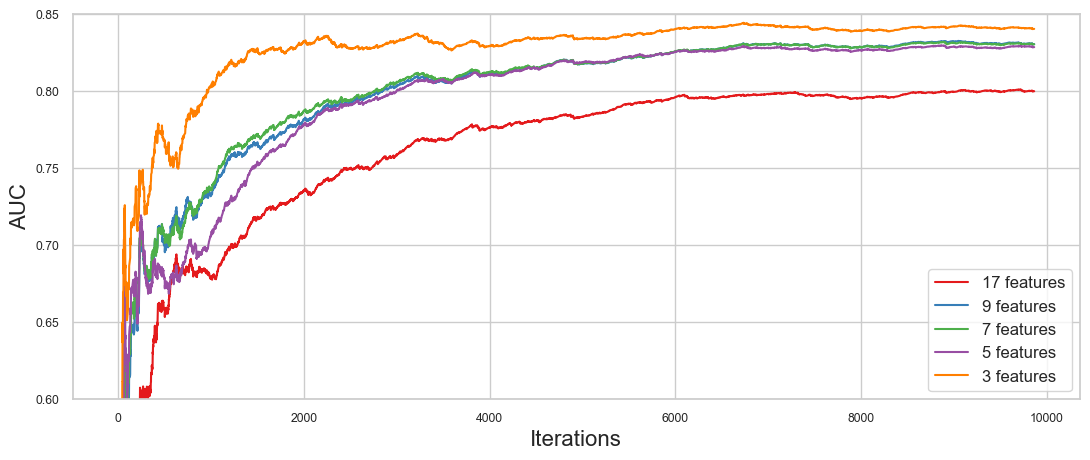

In [210]:
fig = plt.figure(figsize=(13,5))
# Set the seaborn color palette
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, HoeffdingTree[0], label='17 features')
plt.plot(x, HoeffdingTree_9[0], label='9 features')
plt.plot(x, HoeffdingTree_7[0], label='7 features')
plt.plot(x, HoeffdingTree_5[0], label='5 features')
plt.plot(x, HoeffdingTree_3[0], label='3 features')

# Add labels and title
# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.85)
plt.savefig('hf features.png')
plt.show()

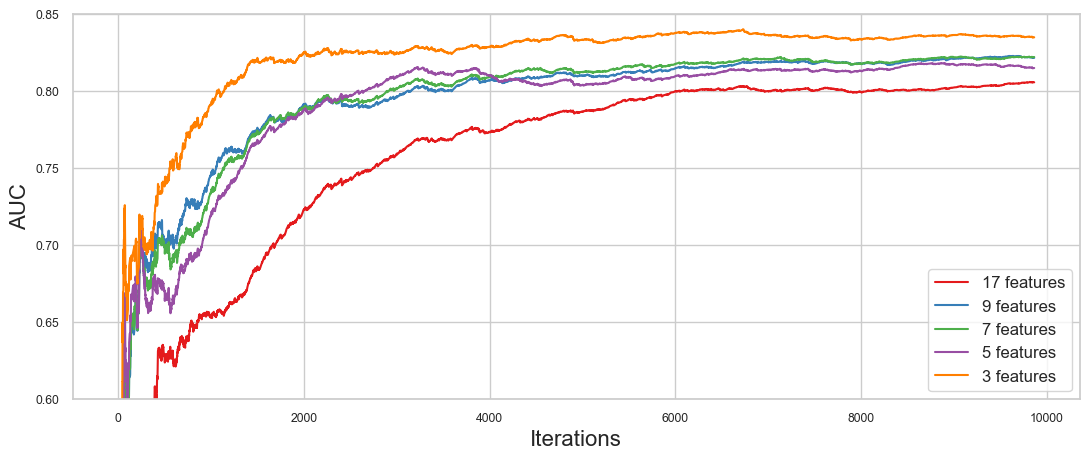

In [211]:
fig = plt.figure(figsize=(13,5))
# Set the seaborn color palette
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, HoeffdingTree_adaptive[0], label='17 features')
plt.plot(x, HoeffdingTree_adaptive_9[0], label='9 features')
plt.plot(x, HoeffdingTree_adaptive_7[0], label='7 features')
plt.plot(x, HoeffdingTree_adaptive_5[0], label='5 features')
plt.plot(x, HoeffdingTree_adaptive_3[0], label='3 features')

# Add labels and title
# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.85)
plt.savefig('hadt features.png')
plt.show()

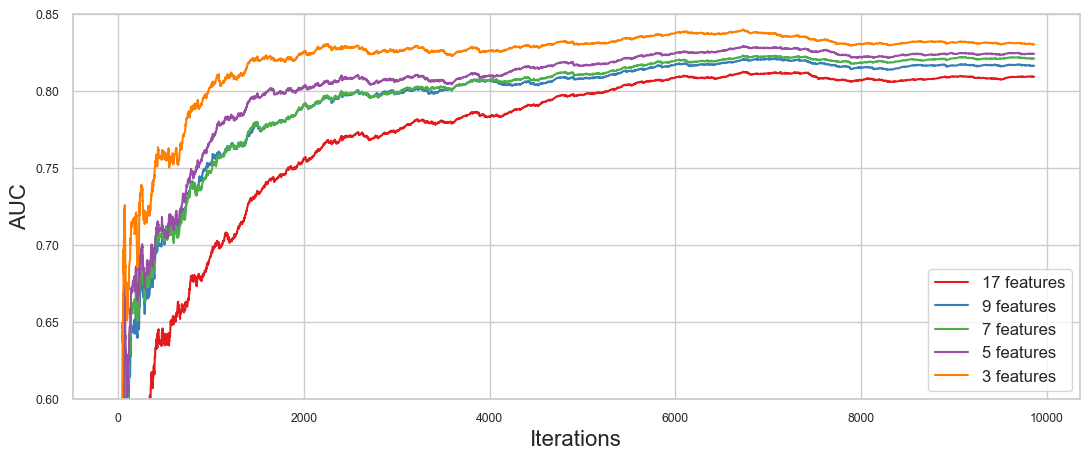

In [212]:
fig = plt.figure(figsize=(13,5))
# Set the seaborn color palette
sns.set_palette('Set1')

sns.set_style("whitegrid")
# Set the style to ticks
#sns.set_style("ticks")

# Define the x-axis as the number of iterations
x = range(len(HoeffdingTree_5[0]))

# Plot the accuracy lists for each model
plt.plot(x, Extremely_fast[0], label='17 features')
plt.plot(x, Extremely_fast_9[0], label='9 features')
plt.plot(x, Extremely_fast_7[0], label='7 features')
plt.plot(x, Extremely_fast_5[0], label='5 features')
plt.plot(x, Extremely_fast_3[0], label='3 features')

# Add labels and title
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('AUC', fontsize=16)
#plt.title('AUC Over Iterations (Top 3 most important features)', fontsize=16, fontweight='bold')

# Add legend
plt.legend(loc='lower right',fontsize=12)
plt.ylim(0.6,0.85)
plt.savefig('efdt.png')
# Show the plot
plt.show()

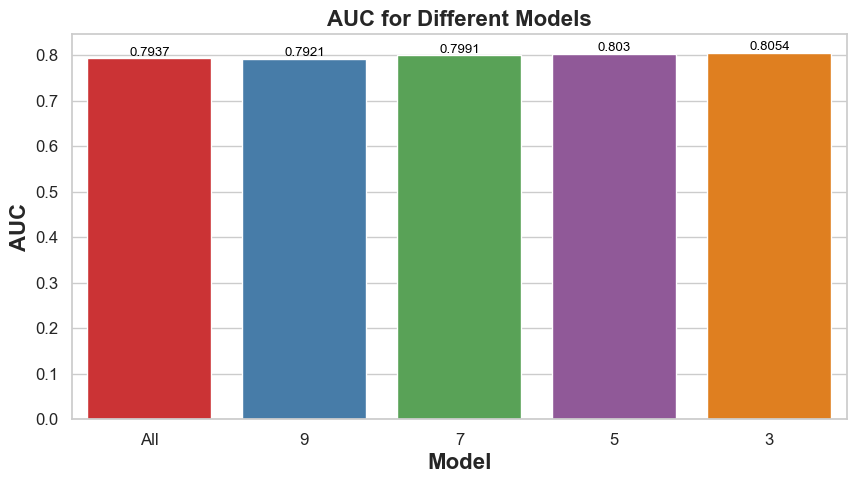

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [SGD_001[-1], SGD_001_9[-1], SGD_001_7[-1], SGD_001_5[-1], SGD_001_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

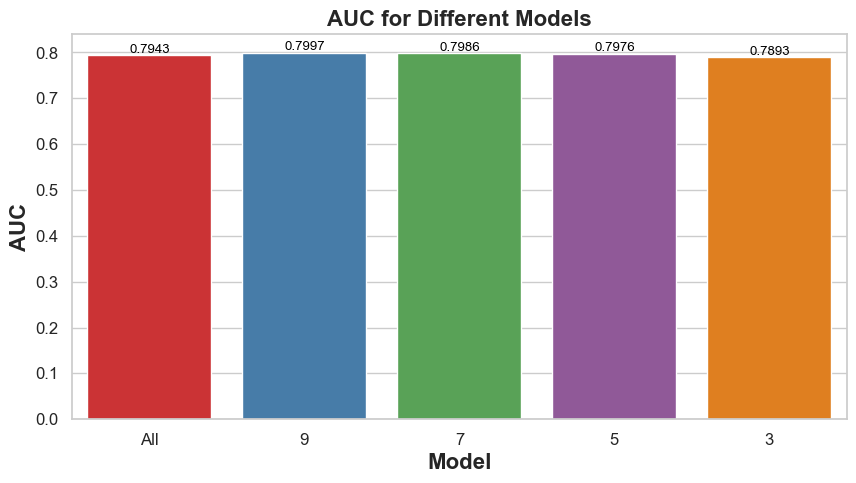

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [passive_aggressive_0001[-1], passive_aggressive_0001_9[-1], passive_aggressive_0001_7[-1], passive_aggressive_0001_5[-1], passive_aggressive_0001_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

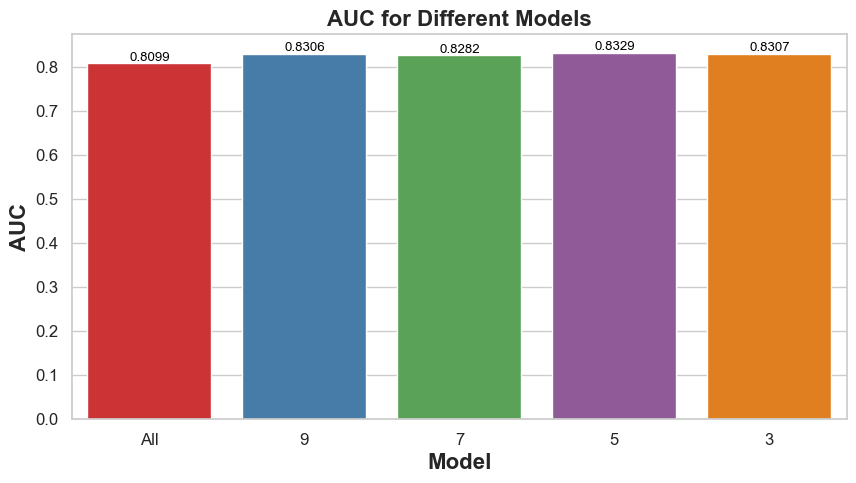

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [HoeffdingTree[-1], HoeffdingTree_9[-1], HoeffdingTree_7[-1], HoeffdingTree_5[-1], HoeffdingTree_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

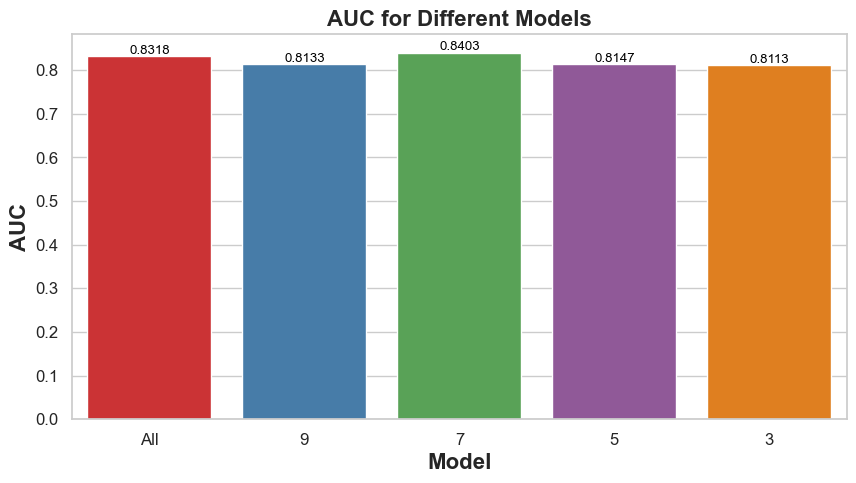

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [HoeffdingTree_adaptive[-1], HoeffdingTree_adaptive_9[-1], HoeffdingTree_adaptive_7[-1], HoeffdingTree_adaptive_5[-1], HoeffdingTree_adaptive_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

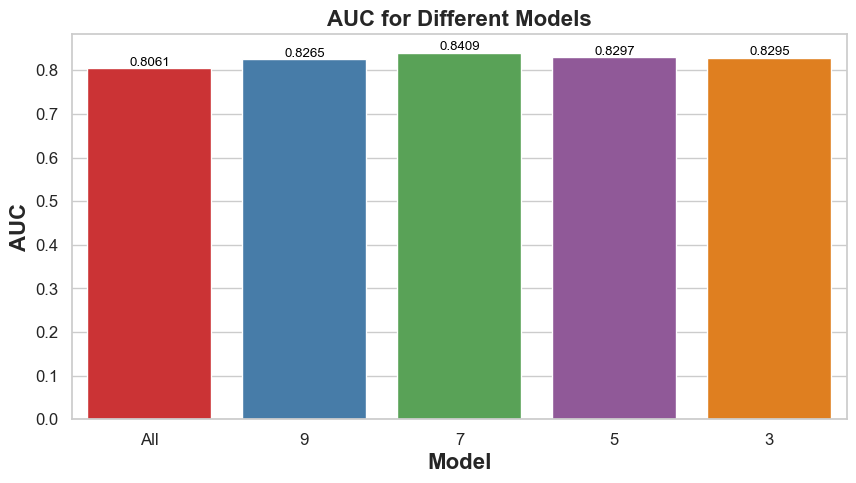

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [Extremely_fast[-1], Extremely_fast_9[-1], Extremely_fast_7[-1], Extremely_fast_5[-1], Extremely_fast_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

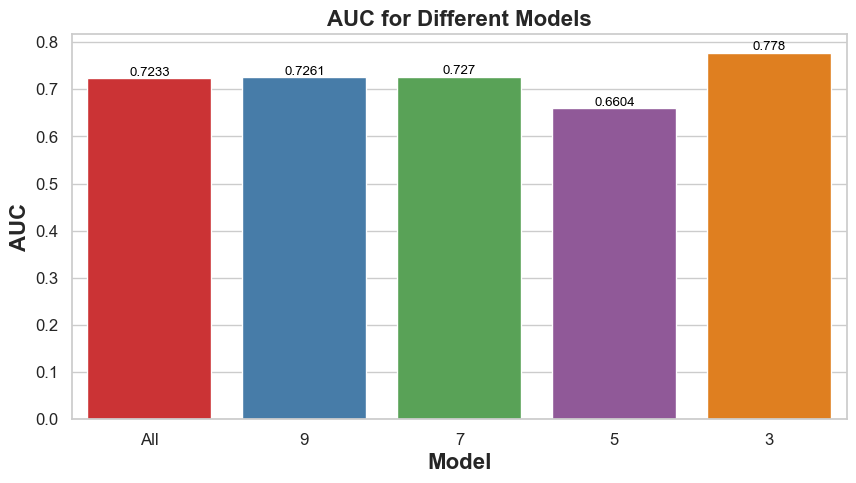

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the models and their corresponding AUC values
models = ['All', '9', '7', '5', '3']
auc_values = [naive[-1], naive_9[-1], naive_7[-1], naive_5[-1], naive_3[-1]]

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=models, y=auc_values, ax=ax)

# Set the x- and y-labels and title
ax.set_xlabel('Model', fontsize=16, fontweight='bold')
ax.set_ylabel('AUC', fontsize=16, fontweight='bold')
ax.set_title('AUC for Different Models', fontsize=16, fontweight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the AUC values as text on the plot
for i, v in enumerate(auc_values):
    ax.text(i, v + 0.005, str(round(v, 4)), color='black', ha='center')

# Show the plot
plt.show()

## Ensemble

In [81]:
df_5_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Revenue']]

# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_5_features, test_size=0.2, random_state=42,stratify=df['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 5), label shape: (9864,)
Test set shape: (2466, 5), label shape: (2466,)


In [82]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

### SGD with 5 features

Training time: 8.11 seconds
Accuracy Train: 0.8724655312246553
Balanced Accuracy Train: 0.8209671522348534
AUC 0.8209671522348533
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.07%   89.55%   92.23%      8338  
       1      56.67%   74.64%   64.42%      1526  
                                                  
   Macro      75.87%   82.10%   78.33%            
   Micro      87.25%   87.25%   87.25%            
Weighted      89.13%   87.25%   87.93%            

                 87.25% accuracy                  
Accuracy: 0.8580697485806975
Precision: [0.94783058 0.53018868]
Recall: [0.88051823 0.73560209]
F1 Score: [0.91293532 0.61622807]
Specifity: 0.8805182341650671
Balanced Accuracy: 0.8080601642029523
AUC: 0.8080601642029525
Confusion matrix:
[[1835  249]
 [ 101  281]]


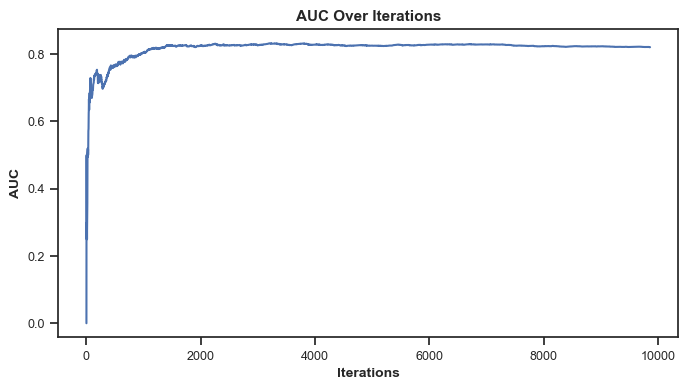

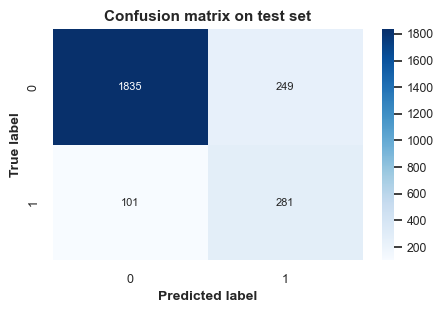

In [83]:
SGD_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD(0.01)),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=5
))

Training time: 6.98 seconds
Accuracy Train: 0.8722627737226277
Balanced Accuracy Train: 0.8200441566615225
AUC 0.8200441566615225
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.04%   89.57%   92.22%      8338  
       1      56.63%   74.44%   64.33%      1526  
                                                  
   Macro      75.83%   82.00%   78.27%            
   Micro      87.23%   87.23%   87.23%            
Weighted      89.10%   87.23%   87.90%            

                 87.23% accuracy                  
Accuracy: 0.8678021086780211
Precision: [0.94393939 0.55761317]
Recall: [0.89683301 0.70942408]
F1 Score: [0.91978346 0.62442396]
Specifity: 0.8968330134357005
Balanced Accuracy: 0.803128548602667
AUC: 0.803128548602667
Confusion matrix:
[[1869  215]
 [ 111  271]]


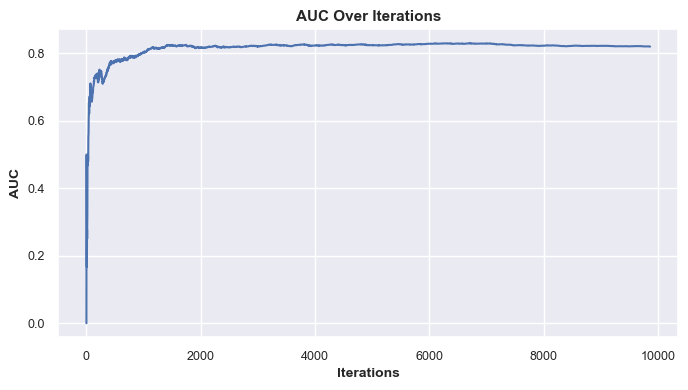

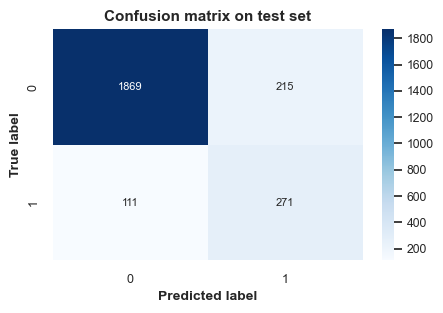

In [84]:
SGD_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD(0.01)),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3
))

Training time: 9.39 seconds
Accuracy Train: 0.866382806163828
Balanced Accuracy Train: 0.8160307292136587
AUC 0.8160307292136587
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      94.98%   88.89%   91.83%      8338  
       1      55.05%   74.31%   63.25%      1526  
                                                  
   Macro      75.01%   81.60%   77.54%            
   Micro      86.64%   86.64%   86.64%            
Weighted      88.80%   86.64%   87.41%            

                 86.64% accuracy                  
Accuracy: 0.8775344687753447
Precision: [0.93978282 0.59090909]
Recall: [0.91362764 0.68062827]
F1 Score: [0.92652068 0.63260341]
Specifity: 0.9136276391554703
Balanced Accuracy: 0.7971279557033897
AUC: 0.7971279557033897
Confusion matrix:
[[1904  180]
 [ 122  260]]


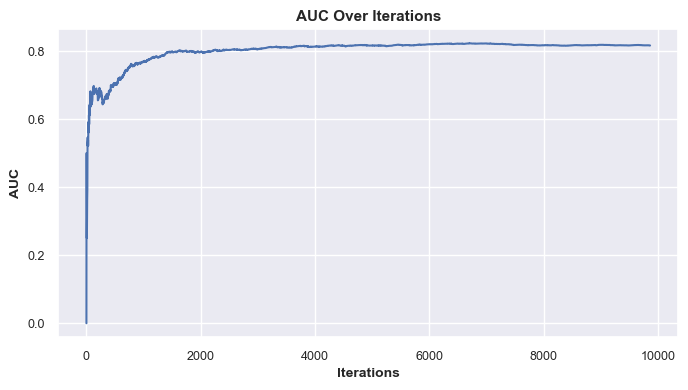

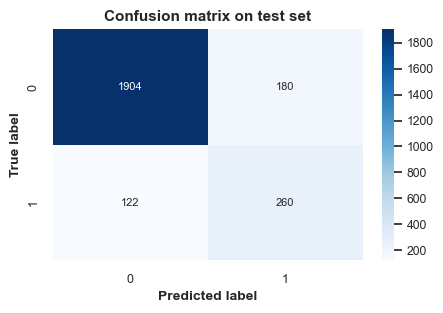

In [85]:
SGD_adaboost=train_evaluate_model(ensemble.AdaBoostClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD(0.01)),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3
,seed=42))

### HFDT  (Bagging)

In [10]:
hfdt_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=20
))

KeyboardInterrupt: 

Training time: 68.50 seconds
Accuracy Train: 0.8433698296836983
Balanced Accuracy Train: 0.8364146746236263
AUC 0.8364146746236262
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      96.38%   84.65%   90.13%      8338  
       1      49.63%   82.63%   62.01%      1526  
                                                  
   Macro      73.00%   83.64%   76.07%            
   Micro      84.34%   84.34%   84.34%            
Weighted      89.15%   84.34%   85.78%            

                 84.34% accuracy                  
Accuracy: 0.8033252230332523
Precision: [0.97001764 0.43267974]
Recall: [0.79174664 0.86649215]
F1 Score: [0.87186262 0.5771578 ]
Specifity: 0.791746641074856
Balanced Accuracy: 0.8291193938358574
AUC: 0.8291193938358573
Confusion matrix:
[[1650  434]
 [  51  331]]


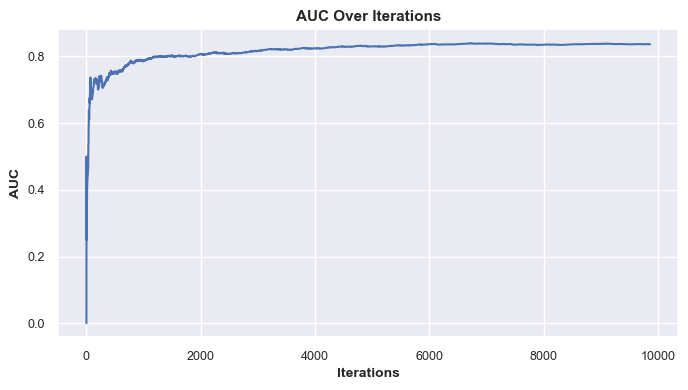

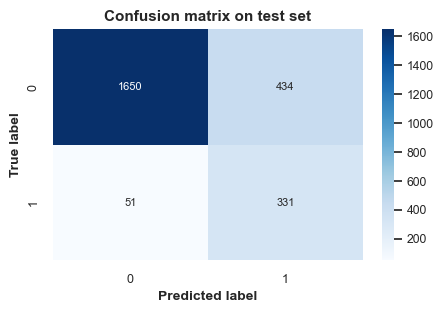

In [14]:
hfdt_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=tree.HoeffdingAdaptiveTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=7
))

Training time: 67.70 seconds
Accuracy Train: 0.855940794809408
Balanced Accuracy Train: 0.7857623060050984
AUC 0.7857623060050984
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      93.88%   88.74%   91.24%      8338  
       1      52.65%   68.41%   59.50%      1526  
                                                  
   Macro      73.27%   78.58%   75.37%            
   Micro      85.59%   85.59%   85.59%            
Weighted      87.50%   85.59%   86.33%            

                 85.59% accuracy                  
Accuracy: 0.8552311435523114
Precision: [0.92390771 0.52913753]
Recall: [0.90307102 0.59424084]
F1 Score: [0.91337054 0.55980271]
Specifity: 0.9030710172744721
Balanced Accuracy: 0.7486559274854037
AUC: 0.7486559274854035
Confusion matrix:
[[1882  202]
 [ 155  227]]


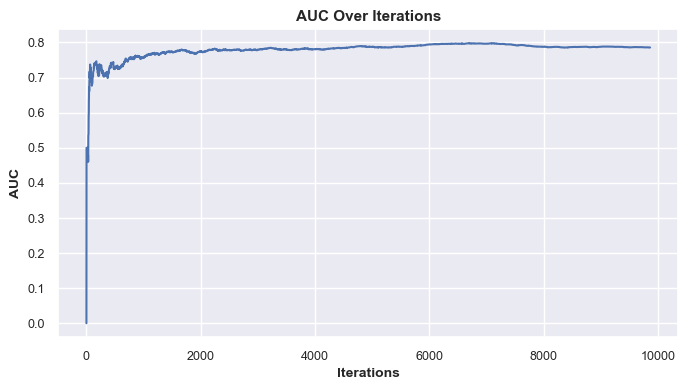

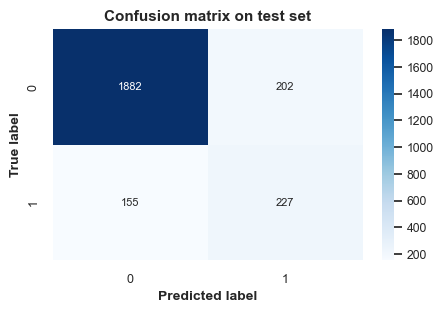

In [95]:
hfdt_bagging=train_evaluate_model(ensemble.AdaBoostClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=tree.HoeffdingAdaptiveTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=10
))

In [ ]:
HoeffdingTree_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() | imblearn.RandomOverSampler(
        classifier=naive_bayes.GaussianNB(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3,
))

### HFDT (4 models)

Training time: 39.89 seconds
Accuracy Train: 0.8756082725060828
Balanced Accuracy Train: 0.843438054767967
AUC 0.8434380547679668
Classification Report            Precision   Recall   F1       Support  
                                                  
       0      95.99%   89.00%   92.36%      8338  
       1      57.01%   79.69%   66.47%      1526  
                                                  
   Macro      76.50%   84.34%   79.42%            
   Micro      87.56%   87.56%   87.56%            
Weighted      89.96%   87.56%   88.36%            

                 87.56% accuracy                  
Accuracy: 0.870235198702352
Precision: [0.95557851 0.55849057]
Recall: [0.88771593 0.77486911]
F1 Score: [0.92039801 0.64912281]
Specifity: 0.8877159309021113
Balanced Accuracy: 0.8312925204248777
AUC: 0.8312925204248778
Confusion matrix:
[[1850  234]
 [  86  296]]


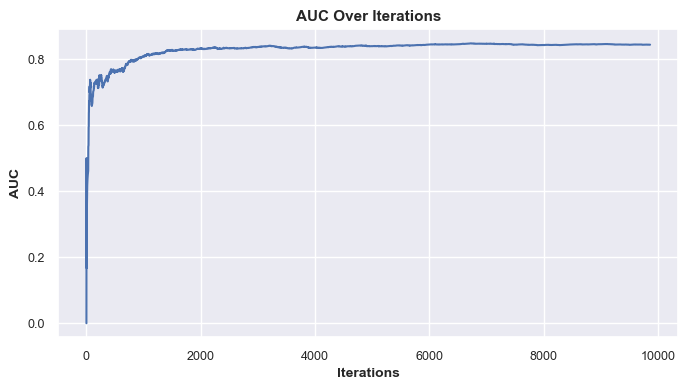

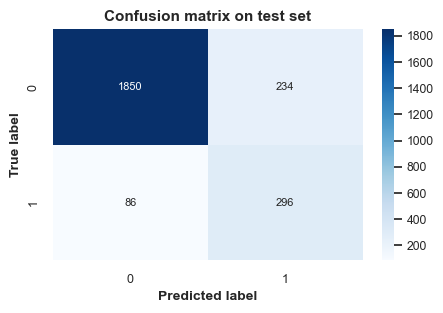

In [91]:
HoeffdingTree_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=20,
))

### SGD 3 models

In [ ]:
SGD_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD()),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3
),1,0)

### SGD 4 models

In [ ]:
SGD_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD()),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=4
),1,0)

## Adaboost

### Hoefding with 5 features

In [ ]:
df_5_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_5_features, test_size=0.2, random_state=42,stratify=df_7_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

In [ ]:
def train_evaluate_model(model, window_size, overlap_size):
    # Initialize the model
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


    #balanced_acc=metrics.V

    # Define the sliding window
    sliding_window = deque(maxlen=window_size)

    # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]
    window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)
        
        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value
        
        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        sliding_window.append((xi, yi))
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
      


        # Update window index
        window_index.append(i)
    

        # Train the model on the most recent data in the window
        if len(sliding_window) == window_size:
            for x_window, y_window in sliding_window:
                model.learn_one(x_window, y_window)

            # Shift the window forward by the overlap amount
            for i in range(overlap_size):
                sliding_window.popleft()
                
    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)

    
    # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)
        
        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value
            
        y_pred_test_list.append(y_pred_test)
        
        

    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc = roc_auc_score(test_label, y_pred_test_list)
    


    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc)

    

    # Print confusion matrix
    print('Confusion matrix:')
    print(cm)

    # Visualize accuracy on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(window_index, acc_list)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('Accuracy',fontweight='bold',size=10)
    plt.title('Accuracy Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()
    
     # Visualize balanced accuracy on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(window_index, bal_acc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('Balanced',fontweight='bold',size=10)
    plt.title('Balanced Accuracy Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()
    
    
    # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(window_index, auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return acc_list,bal_acc,auc

In [ ]:
HoeffdingTree_adaboost_5_features=train_evaluate_model(ensemble.AdaBoostClassifier(
        model=preprocessing.StandardScaler()|imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3,seed=42
),1,0)

In [ ]:
HoeffdingTree_bagging_5=train_evaluate_model(ensemble.BaggingClassifier(
     model=preprocessing.StandardScaler()|imblearn.RandomOverSampler(
        classifier=tree.HoeffdingTreeClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=4,seed=2
),1,0)

In [ ]:
SGD_bagging=train_evaluate_model(ensemble.BaggingClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD()),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3,seed=42
),1,0)

In [ ]:
SGD_ada=train_evaluate_model(ensemble.AdaBoostClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD()),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3,seed=42
),1,0)

In [ ]:
SGD_bagging=train_evaluate_model(ensemble.AdaBoostClassifier(
    model=preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=linear_model.LogisticRegression(optimizer=optim.SGD()),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=6,seed=42
),1,0)

In [ ]:
arf_bagging=train_evaluate_model(ensemble.AdaBoostClassifier(
    model=imblearn.RandomOverSampler(
        classifier=forest.ARFClassifier(),
        desired_dist={0: .5, 1: .5},
        seed=42
    ),n_models=3,
),1,0)

In [ ]:
#arf=train_evaluate_model(preprocessing.StandardScaler()|forest.ARFClassifier(), 1, 0)

In [ ]:
        classifier=tree.ExtremelyFastDecisionTreeClassifier(),


## Voting Classifier

In [ ]:
df_7_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Administrative_Duration',
 'Month',
 'Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_7_features, test_size=0.2, random_state=42,stratify=df_7_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

In [ ]:
def train_evaluate_model(model):    
    model = model

    # Define the evaluation metric
    metric = metrics.Accuracy()
    balanced_accuracy=metrics.BalancedAccuracy()
    auc_metric = metrics.ROCAUC()
    report = metrics.ClassificationReport()


        #balanced_acc=metrics.V

    # Define the sliding window
    #sliding_window = deque(maxlen=window_size)

        # Initialize accuracy and window index lists
    acc_list = []
    bal_acc=[]
    auc=[]

    #window_index = []

    # Train the model on the sliding window
    start_time = time.time()
    for i, (xi, yi) in enumerate(stream.iter_pandas(X_train, train_label, shuffle=True, seed=1)):
        y_pred = model.predict_one(xi)

        if y_pred is not None:
            y_pred = int(y_pred)
        else:
            y_pred = 0 # or any default value

        metric.update(y_true=yi, y_pred=y_pred)
        balanced_accuracy.update(y_true=yi, y_pred=y_pred)
        auc_metric.update(y_true=yi, y_pred=y_pred)
        acc_list.append(metric.get())
        bal_acc.append(balanced_accuracy.get())
        auc.append(auc_metric.get())
        report.update(y_true=yi, y_pred=y_pred)
            # Update window index
            #window_index.append(i)

        model.learn_one(xi, yi)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training time: {training_time:.2f} seconds')
    print('Accuracy Train:',metric.get())
    print('Balanced Accuracy Train:',balanced_accuracy.get())
    print('AUC',auc_metric.get())
    print('Classification Report',report)


        # Compute predictions on the test set
    y_pred_test_list = []
    for xi, yi in stream.iter_pandas(X_test, test_label):
        y_pred_test = model.predict_one(xi)

        if y_pred_test is not None:
            y_pred_test = int(y_pred_test)
        else:
            y_pred_test = 0 # or any default value

        y_pred_test_list.append(y_pred_test)


    # Compute evaluation metrics on the test set
    accuracy = accuracy_score(test_label, y_pred_test_list)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_label, y_pred_test_list, average=None)
    specificity = specificity_score(test_label, y_pred_test_list)
    # Compute confusion matrix
    cm = confusion_matrix(test_label, y_pred_test_list)
    bal_ac=balanced_accuracy_score(test_label, y_pred_test_list)
    roc_auc_test = roc_auc_score(test_label, y_pred_test_list)



    # Print accuracy, precision, recall, and F1 score
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    print('Specifity:', specificity)
    print('Balanced Accuracy:',bal_ac)
    print('AUC:', roc_auc_test)   

        # Print confusion matrix
    print('Confusion matrix:')
    print(cm)    

        # Visualize AUC on train set
    fig = plt.figure(figsize=(8,4))
    plt.plot(auc)
    plt.xlabel('Iterations',fontweight='bold',size=10)
    plt.ylabel('AUC',fontweight='bold',size=10)
    plt.title('AUC Over Iterations',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.show()

    auc_values=auc

    # Visualize confusion matrix
    fig = plt.figure(figsize=(5,3))
    sns.set(font_scale=0.8)
    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted label',size=10,fontweight='bold')
    plt.ylabel('True label',size=10,fontweight='bold')
    plt.title('Confusion matrix on test set',size=11,fontweight='bold')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)   
    plt.show() 
    
    return auc_values, roc_auc_test

In [ ]:
voting=train_evaluate_model(preprocessing.StandardScaler() |
    imblearn.RandomOverSampler(
       classifier=ensemble.VotingClassifier([
         linear_model.PassiveAggressive(),
         naive_bayes.GaussianNB()]),
        desired_dist={0: .5, 1: .5},
        seed=42
    ))

#arf=train_evaluate_model(preprocessing.StandardScaler()|forest.ARFClassifier(), 1, 0)

## Batch

In [17]:
# Split the dataset into training and testing sets
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, train_label)

# Initialize a logistic regression model with SGD optimizer
clf = DecisionTreeClassifier(criterion='entropy')

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7378995789410216
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2084
           1       0.56      0.55      0.56       382

    accuracy                           0.86      2466
   macro avg       0.74      0.74      0.74      2466
weighted avg       0.86      0.86      0.86      2466



In [18]:
clf = SGDClassifier(loss='log', alpha=0.001, random_state=42)

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.805421008732703
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2084
           1       0.52      0.74      0.61       382

    accuracy                           0.85      2466
   macro avg       0.73      0.81      0.76      2466
weighted avg       0.88      0.85      0.86      2466



In [19]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7186240717106652
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      2084
           1       0.27      0.87      0.41       382

    accuracy                           0.61      2466
   macro avg       0.61      0.72      0.56      2466
weighted avg       0.85      0.61      0.67      2466



### 9 features

In [20]:
df_9_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Administrative_Duration',
 'Month',
 'TrafficType',
 'Administrative','Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_9_features, test_size=0.2, random_state=42,stratify=df_9_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 9), label shape: (9864,)
Test set shape: (2466, 9), label shape: (2466,)


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
    
# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, train_label)

# Initialize a logistic regression model with SGD optimizer
clf = DecisionTreeClassifier(random_state=42,criterion='entropy')

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7251811357538362
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      2084
           1       0.56      0.53      0.54       382

    accuracy                           0.86      2466
   macro avg       0.74      0.73      0.73      2466
weighted avg       0.86      0.86      0.86      2466



In [22]:
clf = SGDClassifier(loss='log', alpha=0.001)

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.8023233612364462
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2084
           1       0.52      0.73      0.60       382

    accuracy                           0.85      2466
   macro avg       0.73      0.80      0.76      2466
weighted avg       0.88      0.85      0.86      2466



In [23]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7254486941142186
              precision    recall  f1-score   support

           0       0.95      0.61      0.74      2084
           1       0.28      0.84      0.42       382

    accuracy                           0.64      2466
   macro avg       0.62      0.73      0.58      2466
weighted avg       0.85      0.64      0.69      2466



### 7 Features

In [24]:
df_7_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Administrative_Duration',
 'Month','Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_7_features, test_size=0.2, random_state=42,stratify=df_7_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 7), label shape: (9864,)
Test set shape: (2466, 7), label shape: (2466,)


In [25]:
# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, train_label)

# Initialize a logistic regression model with SGD optimizer
clf = DecisionTreeClassifier(random_state=42,criterion='entropy')

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7392084794645818
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2084
           1       0.56      0.56      0.56       382

    accuracy                           0.86      2466
   macro avg       0.74      0.74      0.74      2466
weighted avg       0.86      0.86      0.86      2466



In [26]:
clf = SGDClassifier(loss='log', alpha=0.001, random_state=42)

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.805421008732703
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2084
           1       0.52      0.74      0.61       382

    accuracy                           0.85      2466
   macro avg       0.73      0.81      0.76      2466
weighted avg       0.88      0.85      0.86      2466



In [27]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7186240717106652
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      2084
           1       0.27      0.87      0.41       382

    accuracy                           0.61      2466
   macro avg       0.61      0.72      0.56      2466
weighted avg       0.85      0.61      0.67      2466



### 5 Features

In [28]:
df_5_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'BounceRates',
 'ProductRelated',
 'Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_5_features, test_size=0.2, random_state=42,stratify=df_5_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 5), label shape: (9864,)
Test set shape: (2466, 5), label shape: (2466,)


In [29]:
# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, train_label)

# Initialize a logistic regression model with SGD optimizer
clf = DecisionTreeClassifier(random_state=42,criterion='entropy')

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7094529750479847
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2084
           1       0.53      0.50      0.51       382

    accuracy                           0.85      2466
   macro avg       0.72      0.71      0.71      2466
weighted avg       0.85      0.85      0.85      2466



In [30]:
clf = SGDClassifier(loss='log', alpha=0.001, random_state=42)

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.789842328988755
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2084
           1       0.57      0.67      0.62       382

    accuracy                           0.87      2466
   macro avg       0.75      0.79      0.77      2466
weighted avg       0.88      0.87      0.87      2466



In [31]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.6584912723216528
              precision    recall  f1-score   support

           0       0.95      0.44      0.60      2084
           1       0.22      0.88      0.36       382

    accuracy                           0.51      2466
   macro avg       0.59      0.66      0.48      2466
weighted avg       0.84      0.51      0.56      2466



### 3 Features

In [32]:
df_3_features=df[['PageValues',
 'ExitRates',
 'ProductRelated_Duration',
 'Revenue']]


# split the DataFrame into training and test sets with 80% for training and 20% for testing
X_train, X_test = train_test_split(df_3_features, test_size=0.2, random_state=42,stratify=df_5_features['Revenue'])

# assign the 'Revenue' column as the label for both sets
train_label = X_train['Revenue']
test_label = X_test['Revenue']

# remove the 'Revenue' column from both sets
X_train = X_train.drop('Revenue', axis=1)
X_test = X_test.drop('Revenue', axis=1)

# display the shapes of the resulting sets
print(f"Training set shape: {X_train.shape}, label shape: {train_label.shape}")
print(f"Test set shape: {X_test.shape}, label shape: {test_label.shape}")

Training set shape: (9864, 3), label shape: (9864,)
Test set shape: (2466, 3), label shape: (2466,)


In [33]:
# Scale the training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply random oversampling to the training data
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, train_label)

# Initialize a logistic regression model with SGD optimizer
clf = DecisionTreeClassifier(random_state=42,criterion='entropy')

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.6946631528172764
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2084
           1       0.49      0.48      0.49       382

    accuracy                           0.84      2466
   macro avg       0.70      0.69      0.70      2466
weighted avg       0.84      0.84      0.84      2466



In [34]:
clf = SGDClassifier(loss='log', alpha=0.001, random_state=42)

# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7931585452864508
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2084
           1       0.56      0.68      0.62       382

    accuracy                           0.87      2466
   macro avg       0.75      0.79      0.77      2466
weighted avg       0.88      0.87      0.87      2466



In [35]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
# Train the model on the training data
clf.fit(X_train_oversampled, y_train_oversampled)

# Predict the probability scores for the test data
y_prob = clf.predict(X_test)

# Compute the AUC score
auc_score = roc_auc_score(test_label, y_prob)
print('AUC:', auc_score)
print(classification_report(test_label, y_prob))

AUC: 0.7778888766066063
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2084
           1       0.53      0.66      0.59       382

    accuracy                           0.86      2466
   macro avg       0.73      0.78      0.75      2466
weighted avg       0.87      0.86      0.86      2466



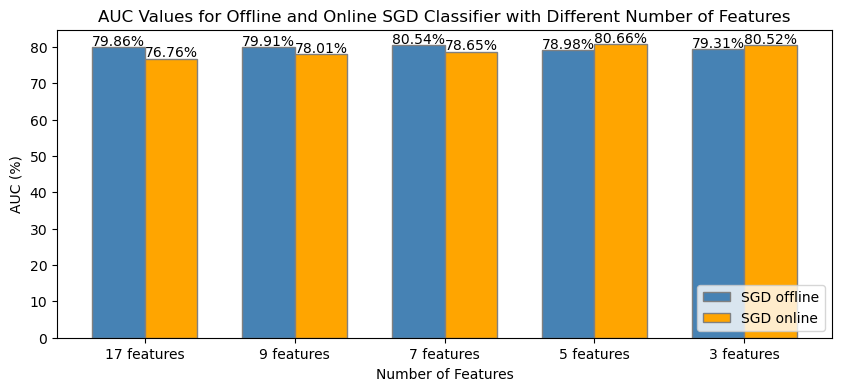

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Define the AUC values for the online and offline versions of the SGD classifier
sgd_online = [76.76, 78.01, 78.65, 80.66, 80.52]
sgd_offline = [79.86, 79.91, 80.54, 78.98, 79.31]

# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10,4))
# Create the plot
plt.bar(r1, sgd_offline, color='steelblue', width=bar_width, edgecolor='grey', label='SGD offline')
plt.bar(r2, sgd_online, color='orange', width=bar_width, edgecolor='grey', label='SGD online')
plt.ylim=([0,100])
# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('AUC (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('AUC Values for Offline and Online SGD Classifier with Different Number of Features')
plt.legend(loc='lower right')


# Add the AUC values as text on top of each bar
for i, v in enumerate(sgd_offline):
    plt.text(i - bar_width/2, v + 0.5, str(v) + '%')
    
for i, v in enumerate(sgd_online):
    plt.text(i + bar_width/2, v + 0.5, str(v) + '%')

# Show the plot
plt.show()

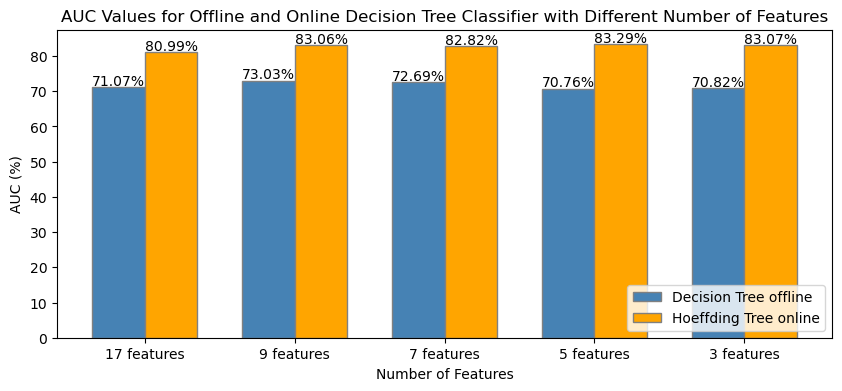

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Define the AUC values for the online and offline versions of the Decision Tree classifier
dt_online = [80.99, 83.06, 82.82, 83.29, 83.07]
dt_offline = [71.07, 73.03, 72.69, 70.76, 70.82]

# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]


plt.figure(figsize=(10,4))
# Create the plot
plt.bar(r1, dt_offline, color='steelblue', width=bar_width, edgecolor='grey', label='Decision Tree offline')
plt.bar(r2, dt_online, color='orange', width=bar_width, edgecolor='grey', label='Hoeffding Tree online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('AUC (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)


# Add a title and legend
plt.title('AUC Values for Offline and Online Decision Tree Classifier with Different Number of Features')
plt.legend(loc='lower right')

# Add the AUC values as text on top of each bar
for i, v in enumerate(dt_offline):
    plt.text(i - bar_width/2, v + 0.5, str(v) + '%')
    
for i, v in enumerate(dt_online):
    plt.text(i + bar_width/2, v + 0.5, str(v) + '%')

# Show the plot
plt.show()


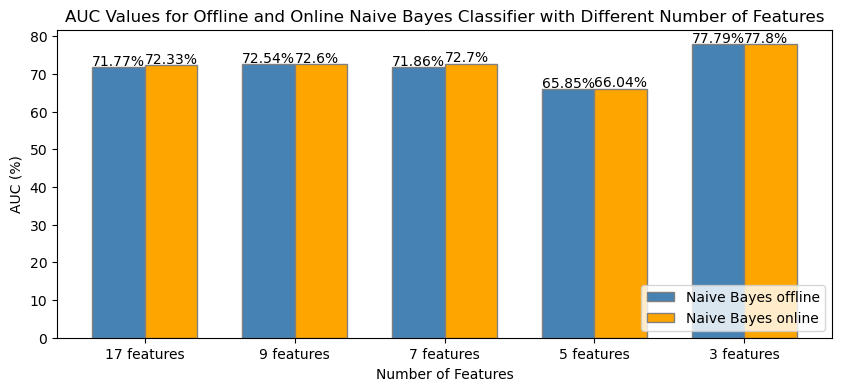

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Define the AUC values for the online and offline versions of the Naive Bayes classifier
naive_online = [72.33, 72.60, 72.70, 66.04, 77.80]
naive_offline = [71.77, 72.54, 71.86, 65.85, 77.79]

# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10,4))
# Create the plot
plt.bar(r1, naive_offline, color='steelblue', width=bar_width, edgecolor='grey', label='Naive Bayes offline')
plt.bar(r2, naive_online, color='orange', width=bar_width, edgecolor='grey', label='Naive Bayes online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('AUC (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('AUC Values for Offline and Online Naive Bayes Classifier with Different Number of Features')
plt.legend(loc='lower right')

# Add the AUC values as text on top of each bar
for i, v in enumerate(naive_offline):
    plt.text(i - bar_width/2, v + 0.5, str(v) + '%')
    
for i, v in enumerate(naive_online):
    plt.text(i + bar_width/2, v + 0.5, str(v) + '%')

# Show the plot
plt.show()


In [ ]:
dt_sensitivity_offline=['52%','53%','54%','49%','51%']
ht_sensitivity_online=['73%','77%','77%','80%','77%']

ht_specificity_online=['89%','89%','89%','87%','89%']
dt_specificity_offline=['91%','93%','91%','92%','91%']


naive_sensitivity_offline=['83%','84%','87%','88%','66%']
naive_sensitivity_online=['81%','82%','86%','88%','69%']

naive_specificity_offline=['61%','61%','57%','44%','89%']
naive_specificity_online=['64%','63%','60%','44%','89%']

sgd_sensitivity_offline=['71%','71%','74%','67%','68%']
sgd_sensitivity_online=['68%','71%','73%','72%','73%']

sgd_specificity_offline=['89%','89%','88%','91%','90%']
sgd_specificity_online=['85.46%','85.05%','84.79%','89.59%','88.53%']

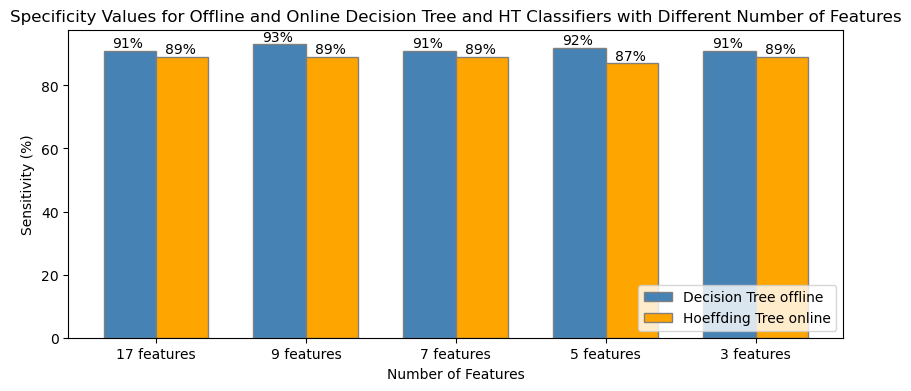

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# Define the sensitivity values for the offline and online versions of the Decision Tree and HT classifiers
ht_specificity_online=[89,89,89,87,89]
dt_specificity_offline=[91,93,91,92,91]
# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 4))
# Create the plot
plt.bar(r1, dt_specificity_offline, color='steelblue', width=bar_width, edgecolor='grey', label='Decision Tree offline')
plt.bar(r2, ht_specificity_online, color='orange', width=bar_width, edgecolor='grey', label='Hoeffding Tree online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('Sensitivity (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('Specificity Values for Offline and Online Decision Tree and HT Classifiers with Different Number of Features')
plt.legend(loc='lower right')

for i, v in enumerate(dt_specificity_offline):
    plt.text(i - bar_width/2 +0.06 , v +1 , str(v) + '%')
    
for i, v in enumerate(ht_specificity_online):
    plt.text(i + bar_width/2  +0.06, v + 1, str(v) + '%')

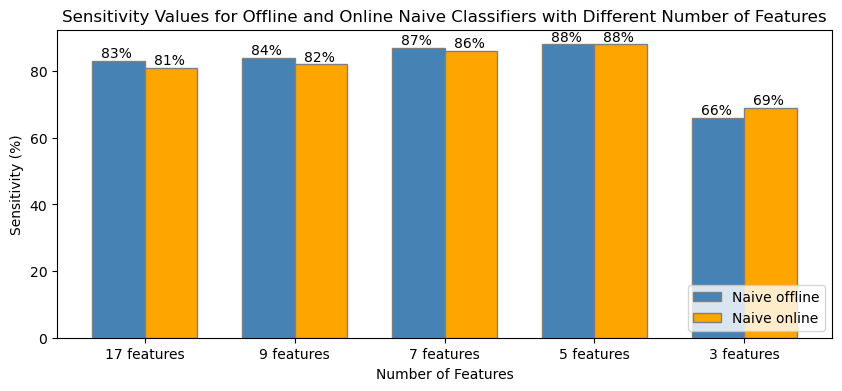

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Define the sensitivity values for the offline and online versions of the Decision Tree and HT classifiers

naive_sensitivity_offline=[83,84,87,88,66]
naive_sensitivity_online=[81,82,86,88,69]
# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 4))
# Create the plot
plt.bar(r1, naive_sensitivity_offline, color='steelblue', width=bar_width, edgecolor='grey', label='Naive offline')
plt.bar(r2, naive_sensitivity_online, color='orange', width=bar_width, edgecolor='grey', label='Naive online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('Sensitivity (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('Sensitivity Values for Offline and Online Naive Classifiers with Different Number of Features')
plt.legend(loc='lower right')

for i, v in enumerate(naive_sensitivity_offline):
    plt.text(i - bar_width/2 +0.06 , v +1 , str(v) + '%')
    
for i, v in enumerate(naive_sensitivity_online):
    plt.text(i + bar_width/2  +0.06, v + 1, str(v) + '%')

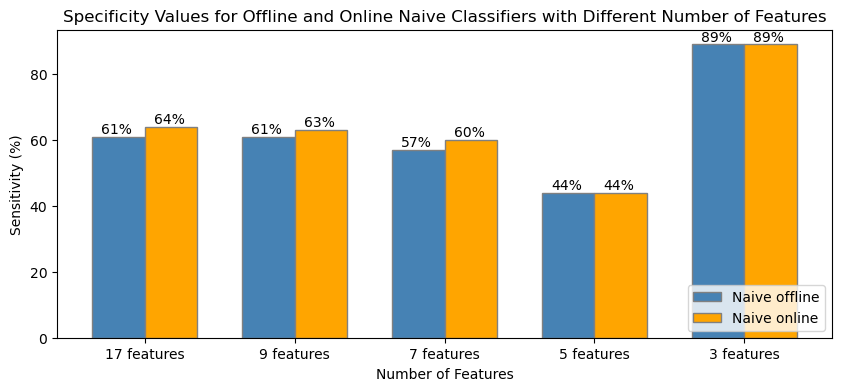

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Define the sensitivity values for the offline and online versions of the Decision Tree and HT classifiers
naive_specificity_offline=[61,61,57,44,89]
naive_specificity_online=[64,63,60,44,89]


# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 4))
# Create the plot
plt.bar(r1, naive_specificity_offline, color='steelblue', width=bar_width, edgecolor='grey', label='Naive offline')
plt.bar(r2, naive_specificity_online, color='orange', width=bar_width, edgecolor='grey', label='Naive online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('Sensitivity (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('Specificity Values for Offline and Online Naive Classifiers with Different Number of Features')
plt.legend(loc='lower right')

for i, v in enumerate(naive_specificity_offline):
    plt.text(i - bar_width/2 +0.06 , v +1 , str(v) + '%')
    
for i, v in enumerate(naive_specificity_online):
    plt.text(i + bar_width/2  +0.06, v + 1, str(v) + '%')

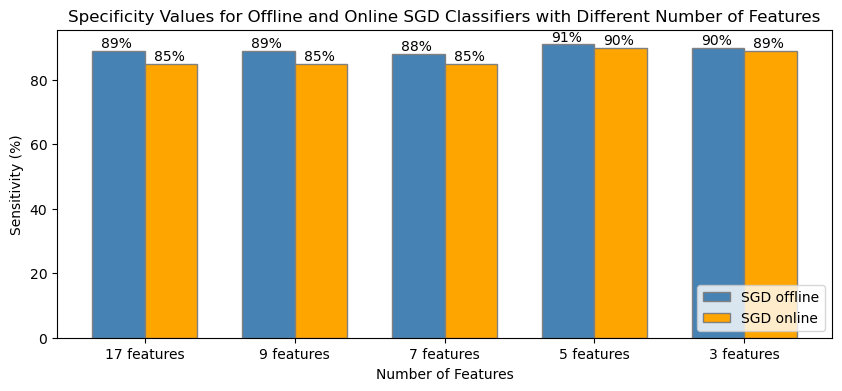

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Define the sensitivity values for the offline and online versions of the Decision Tree and HT classifiers
sgd_specificity_offline=[89,89,88,91,90]
sgd_specificity_online=[85,85,85,90,89]
# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Set the width of the bars
bar_width = 0.35

# Set the x positions of the bars
r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 4))
# Create the plot
plt.bar(r1, sgd_specificity_offline, color='steelblue', width=bar_width, edgecolor='grey', label='SGD offline')
plt.bar(r2, sgd_specificity_online, color='orange', width=bar_width, edgecolor='grey', label='SGD online')

# Add xticks on the middle of the group bars
plt.xlabel('Number of Features')
plt.ylabel('Sensitivity (%)')
plt.xticks([r + bar_width/2 for r in range(len(features))], features)

# Add a title and legend
plt.title('Specificity Values for Offline and Online SGD Classifiers with Different Number of Features')
plt.legend(loc='lower right')

for i, v in enumerate(sgd_specificity_offline):
    plt.text(i - bar_width/2 +0.06 , v +1 , str(v) + '%')
    
for i, v in enumerate(sgd_specificity_online):
    plt.text(i + bar_width/2  +0.06, v + 1, str(v) + '%')

In [17]:
import plotly.graph_objs as go

# Define the sensitivity values for the offline and online versions of the Decision Tree and HT classifiers
sgd_specificity_offline=[89,89,88,91,90]
sgd_specificity_online=[85,85,85,90,89]
# Define the number of features for each model
features = ['17 features', '9 features', '7 features', '5 features', '3 features']

# Define the data
offline_trace = go.Bar(
    x=features,
    y=sgd_specificity_offline,
    name='SGD offline',
    text=[f"{val}%" for val in sgd_specificity_offline],
    textposition='auto',
    marker=dict(color='steelblue')
)
online_trace = go.Bar(
    x=features,
    y=sgd_specificity_online,
    name='SGD online',
    text=[f"{val}%" for val in sgd_specificity_online],
    textposition='auto',
    marker=dict(color='orange')
)
data = [offline_trace, online_trace]

# Define the layout
layout = go.Layout(
    title='Specificity Values for Offline and Online SGD Classifiers with Different Number of Features',
    xaxis=dict(title='Number of Features', tickfont=dict(size=16, family='Arial, bold')),
    yaxis=dict(title='Specificity (%)', tickfont=dict(size=14, family='Arial, bold')),
    font=dict(size=18, family='Arial, bold'),
    legend=dict(
        x=1.02,  # move legend to the right of the chart
        y=0.5,   # center legend vertically
        orientation='v',
        font=dict(size=14)
    )
)

# Create and show the figure
fig = go.Figure(data=data, layout=layout)
fig.show()
